In [5]:
import os
import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ───────────────────────── 설정 ─────────────────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_results")
SEED = 42
N_SPLITS = 5
N_ESTIMATORS = 800
MAX_DEPTH = None
N_JOBS = -1
RANDOM_STATE = SEED

OUTDIR.mkdir(parents=True, exist_ok=True)

# 로그 설정
log_path = OUTDIR / f"train_random_forest_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("RF_Trainer")

logger.info("===== RandomForest Regression for Ar_273K dataset =====")
logger.info(f"DATA_PATH      : {DATA_PATH}")
logger.info(f"OUTDIR         : {OUTDIR}")
logger.info(f"SEED           : {SEED}, N_SPLITS: {N_SPLITS}")
logger.info(f"RF params      : n_estimators={N_ESTIMATORS}, max_depth={MAX_DEPTH}, n_jobs={N_JOBS}")

# ───────────────────── 데이터 로드 & 피처 선택 ─────────────────────
df = pd.read_csv(DATA_PATH)

# 사용자가 제시한 전체 컬럼 참고(문자열 주석): filename, LCD, PLD, LFPD, cm3_g, ASA_m2_cm3, ASA_m2_g,
# NASA_m2_cm3, NASA_m2_g, AV_VF, AV_cm3_g, NAV_cm3_g, Has_OMS, name, Input, Output
# 구조 피처만 학습에 사용: (filename, name, Input, Output 제외)
FEATURES = [
    "LCD", "PLD", "LFPD", "cm3_g", "ASA_m2_cm3", "ASA_m2_g",
    "NASA_m2_cm3", "NASA_m2_g", "AV_VF", "AV_cm3_g", "NAV_cm3_g", "Has_OMS"
]
META_KEEP = ["filename", "name"]  # 추적용으로 예측 결과에 함께 저장
TARGET = "Output"

missing_cols = [c for c in FEATURES + META_KEEP + [TARGET] if c not in df.columns]
if missing_cols:
    logger.error(f"Dataset missing columns: {missing_cols}")
    raise KeyError(f"Dataset missing columns: {missing_cols}")

# 타입 정리 (Has_OMS가 bool/object인 경우 int로)
if df["Has_OMS"].dtype == bool:
    df["Has_OMS"] = df["Has_OMS"].astype(int)
elif not np.issubdtype(df["Has_OMS"].dtype, np.number):
    # 가능한 경우: 'True'/'False' 문자열
    df["Has_OMS"] = df["Has_OMS"].astype(str).str.lower().map({"true":1, "false":0})
    df["Has_OMS"] = df["Has_OMS"].fillna(0).astype(int)

# NaN 처리: 학습/평가 안정성을 위해 학습에 필요한 컬럼에서 NaN 제거(로그 기록)
before_rows = len(df)
df = df.dropna(subset=FEATURES + [TARGET])
after_rows = len(df)
logger.info(f"Drop NaN rows for FEATURES+TARGET: {before_rows} -> {after_rows} rows")

X_all = df[FEATURES].copy()
y_all = df[TARGET].astype(float).copy()
meta_all = df[META_KEEP].copy()

# ───────────────────── 모델 & KFold ─────────────────────
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

metrics_rows = []
feat_importance_collect = []

for fold, (tr_idx, te_idx) in enumerate(kf.split(X_all), start=1):
    logger.info(f"----- Fold {fold}/{N_SPLITS} -----")
    X_tr, X_te = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_tr, y_te = y_all.iloc[tr_idx], y_all.iloc[te_idx]
    meta_te = meta_all.iloc[te_idx].reset_index(drop=True)

    # 모델 생성
    rf = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        oob_score=False
    )

    # 학습
    logger.info(f"Train size={len(X_tr)}, Test size={len(X_te)}")
    rf.fit(X_tr, y_tr)

    # 예측
    y_pred = rf.predict(X_te)

    # 메트릭
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = mean_squared_error(y_te, y_pred)
    mape = np.mean(np.abs((y_te - y_pred) / np.clip(np.abs(y_te), 1e-12, None))) * 100.0

    logger.info(f"Fold {fold} | R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f} | MAPE%={mape:.3f}")

    metrics_rows.append({
        "fold": fold, "R2": r2, "MAE": mae, "RMSE": rmse, "MAPE_percent": mape,
        "n_train": len(X_tr), "n_test": len(X_te)
    })

    # 예측 결과 저장 (테스트셋 입력 피처 + filename + name + 실제/예측)
    pred_df = pd.concat([meta_te, X_te.reset_index(drop=True)], axis=1)
    pred_df["y_true"] = y_te.values
    pred_df["y_pred"] = y_pred
    pred_out = OUTDIR / f"predictions_fold{fold}.csv"
    pred_df.to_csv(pred_out, index=False, encoding="utf-8-sig")
    logger.info(f"Saved predictions: {pred_out}")

    # 피처 중요도 수집
    feat_importance_collect.append(pd.Series(rf.feature_importances_, index=FEATURES, name=f"fold{fold}"))

# 메트릭 요약 저장
metrics_df = pd.DataFrame(metrics_rows)
metrics_df.loc["mean"] = {
    "fold": "mean",
    "R2": metrics_df["R2"].mean(),
    "MAE": metrics_df["MAE"].mean(),
    "RMSE": metrics_df["RMSE"].mean(),
    "MAPE_percent": metrics_df["MAPE_percent"].mean(),
    "n_train": metrics_df["n_train"].mean(),
    "n_test": metrics_df["n_test"].mean()
}
metrics_path = OUTDIR / "metrics_kfold.csv"
metrics_df.to_csv(metrics_path, index=False, encoding="utf-8-sig")
logger.info(f"Saved metrics: {metrics_path}")

# 피처 중요도 평균 저장
feat_imp_df = pd.concat(feat_importance_collect, axis=1)
feat_imp_df["mean_importance"] = feat_imp_df.mean(axis=1)
feat_imp_df = feat_imp_df.sort_values("mean_importance", ascending=False)
feat_imp_path = OUTDIR / "feature_importances.csv"
feat_imp_df.to_csv(feat_imp_path, encoding="utf-8-sig")
logger.info(f"Saved feature importances: {feat_imp_path}")

logger.info("===== Done. (Note: Regression has no 'accuracy'; use R2/MAE/RMSE/MAPE) =====")


2025-09-06 21:22:25,019 | INFO | ===== RandomForest Regression for Ar_273K dataset =====
2025-09-06 21:22:25,021 | INFO | DATA_PATH      : ../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv
2025-09-06 21:22:25,023 | INFO | OUTDIR         : RF_Ar273K_results
2025-09-06 21:22:25,025 | INFO | SEED           : 42, N_SPLITS: 5
2025-09-06 21:22:25,027 | INFO | RF params      : n_estimators=800, max_depth=None, n_jobs=-1
2025-09-06 21:22:25,085 | INFO | Drop NaN rows for FEATURES+TARGET: 7766 -> 7766 rows
2025-09-06 21:22:25,100 | INFO | ----- Fold 1/5 -----
2025-09-06 21:22:25,213 | INFO | Train size=6212, Test size=1554
2025-09-06 21:22:31,682 | INFO | Fold 1 | R2=0.749077 | MAE=0.604815 | RMSE=0.825154 | MAPE%=18.895
2025-09-06 21:22:31,709 | INFO | Saved predictions: RF_Ar273K_results\predictions_fold1.csv
2025-09-06 21:22:31,861 | INFO | ----- Fold 2/5 -----
2025-09-06 21:22:31,953 | INFO | Train size=6213, Test size=1553
2025-09-06 21:22:38,017 | INFO | Fold 2 

In [7]:
import os
import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ───────────────────────── 설정 ─────────────────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_results2")
SEED = 42
N_SPLITS = 5
N_ESTIMATORS = 800
MAX_DEPTH = None
N_JOBS = -1
RANDOM_STATE = SEED

OUTDIR.mkdir(parents=True, exist_ok=True)

# 로그 설정
log_path = OUTDIR / f"train_random_forest_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("RF_Trainer")

logger.info("===== RandomForest Regression for Ar_273K dataset =====")
logger.info(f"DATA_PATH      : {DATA_PATH}")
logger.info(f"OUTDIR         : {OUTDIR}")
logger.info(f"SEED           : {SEED}, N_SPLITS: {N_SPLITS}")
logger.info(f"RF params      : n_estimators={N_ESTIMATORS}, max_depth={MAX_DEPTH}, n_jobs={N_JOBS}")

# ───────────────────── 데이터 로드 & 피처 선택 ─────────────────────
df = pd.read_csv(DATA_PATH)

# 사용자가 제시한 전체 컬럼 참고(문자열 주석): filename, LCD, PLD, LFPD, cm3_g, ASA_m2_cm3, ASA_m2_g,
# NASA_m2_cm3, NASA_m2_g, AV_VF, AV_cm3_g, NAV_cm3_g, Has_OMS, name, Input, Output
# 구조 피처만 학습에 사용: (filename, name, Input, Output 제외)
FEATURES = [
    "LCD", "PLD", "LFPD", "cm3_g", "ASA_m2_cm3", "ASA_m2_g",
    "NASA_m2_cm3", "NASA_m2_g", "AV_VF", "AV_cm3_g", "NAV_cm3_g", "Has_OMS", 'Input'
]
META_KEEP = ["filename", "name"]  # 추적용으로 예측 결과에 함께 저장
TARGET = "Output"

missing_cols = [c for c in FEATURES + META_KEEP + [TARGET] if c not in df.columns]
if missing_cols:
    logger.error(f"Dataset missing columns: {missing_cols}")
    raise KeyError(f"Dataset missing columns: {missing_cols}")

# 타입 정리 (Has_OMS가 bool/object인 경우 int로)
if df["Has_OMS"].dtype == bool:
    df["Has_OMS"] = df["Has_OMS"].astype(int)
elif not np.issubdtype(df["Has_OMS"].dtype, np.number):
    # 가능한 경우: 'True'/'False' 문자열
    df["Has_OMS"] = df["Has_OMS"].astype(str).str.lower().map({"true":1, "false":0})
    df["Has_OMS"] = df["Has_OMS"].fillna(0).astype(int)

# NaN 처리: 학습/평가 안정성을 위해 학습에 필요한 컬럼에서 NaN 제거(로그 기록)
before_rows = len(df)
df = df.dropna(subset=FEATURES + [TARGET])
after_rows = len(df)
logger.info(f"Drop NaN rows for FEATURES+TARGET: {before_rows} -> {after_rows} rows")

X_all = df[FEATURES].copy()
y_all = df[TARGET].astype(float).copy()
meta_all = df[META_KEEP].copy()

# ───────────────────── 모델 & KFold ─────────────────────
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

metrics_rows = []
feat_importance_collect = []

for fold, (tr_idx, te_idx) in enumerate(kf.split(X_all), start=1):
    logger.info(f"----- Fold {fold}/{N_SPLITS} -----")
    X_tr, X_te = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_tr, y_te = y_all.iloc[tr_idx], y_all.iloc[te_idx]
    meta_te = meta_all.iloc[te_idx].reset_index(drop=True)

    # 모델 생성
    rf = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        oob_score=False
    )

    # 학습
    logger.info(f"Train size={len(X_tr)}, Test size={len(X_te)}")
    rf.fit(X_tr, y_tr)

    # 예측
    y_pred = rf.predict(X_te)

    # 메트릭
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = mean_squared_error(y_te, y_pred)
    mape = np.mean(np.abs((y_te - y_pred) / np.clip(np.abs(y_te), 1e-12, None))) * 100.0

    logger.info(f"Fold {fold} | R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f} | MAPE%={mape:.3f}")

    metrics_rows.append({
        "fold": fold, "R2": r2, "MAE": mae, "RMSE": rmse, "MAPE_percent": mape,
        "n_train": len(X_tr), "n_test": len(X_te)
    })

    # 예측 결과 저장 (테스트셋 입력 피처 + filename + name + 실제/예측)
    pred_df = pd.concat([meta_te, X_te.reset_index(drop=True)], axis=1)
    pred_df["y_true"] = y_te.values
    pred_df["y_pred"] = y_pred
    pred_out = OUTDIR / f"predictions_fold{fold}.csv"
    pred_df.to_csv(pred_out, index=False, encoding="utf-8-sig")
    logger.info(f"Saved predictions: {pred_out}")

    # 피처 중요도 수집
    feat_importance_collect.append(pd.Series(rf.feature_importances_, index=FEATURES, name=f"fold{fold}"))

# 메트릭 요약 저장
metrics_df = pd.DataFrame(metrics_rows)
metrics_df.loc["mean"] = {
    "fold": "mean",
    "R2": metrics_df["R2"].mean(),
    "MAE": metrics_df["MAE"].mean(),
    "RMSE": metrics_df["RMSE"].mean(),
    "MAPE_percent": metrics_df["MAPE_percent"].mean(),
    "n_train": metrics_df["n_train"].mean(),
    "n_test": metrics_df["n_test"].mean()
}
metrics_path = OUTDIR / "metrics_kfold.csv"
metrics_df.to_csv(metrics_path, index=False, encoding="utf-8-sig")
logger.info(f"Saved metrics: {metrics_path}")

# 피처 중요도 평균 저장
feat_imp_df = pd.concat(feat_importance_collect, axis=1)
feat_imp_df["mean_importance"] = feat_imp_df.mean(axis=1)
feat_imp_df = feat_imp_df.sort_values("mean_importance", ascending=False)
feat_imp_path = OUTDIR / "feature_importances.csv"
feat_imp_df.to_csv(feat_imp_path, encoding="utf-8-sig")
logger.info(f"Saved feature importances: {feat_imp_path}")

logger.info("===== Done. (Note: Regression has no 'accuracy'; use R2/MAE/RMSE/MAPE) =====")


2025-09-06 21:23:27,658 | INFO | ===== RandomForest Regression for Ar_273K dataset =====
2025-09-06 21:23:27,659 | INFO | DATA_PATH      : ../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv
2025-09-06 21:23:27,660 | INFO | OUTDIR         : RF_Ar273K_results2
2025-09-06 21:23:27,661 | INFO | SEED           : 42, N_SPLITS: 5
2025-09-06 21:23:27,662 | INFO | RF params      : n_estimators=800, max_depth=None, n_jobs=-1
2025-09-06 21:23:27,696 | INFO | Drop NaN rows for FEATURES+TARGET: 7766 -> 7766 rows
2025-09-06 21:23:27,705 | INFO | ----- Fold 1/5 -----
2025-09-06 21:23:27,792 | INFO | Train size=6212, Test size=1554
2025-09-06 21:23:33,851 | INFO | Fold 1 | R2=0.937623 | MAE=0.277987 | RMSE=0.205125 | MAPE%=7.384
2025-09-06 21:23:33,882 | INFO | Saved predictions: RF_Ar273K_results2\predictions_fold1.csv
2025-09-06 21:23:34,051 | INFO | ----- Fold 2/5 -----
2025-09-06 21:23:34,122 | INFO | Train size=6213, Test size=1553
2025-09-06 21:23:40,451 | INFO | Fold 2

In [9]:
import os
import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ───────────────────────── 설정 ─────────────────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_quantile_sampling_results")
SEED = 42                       # 고정 홀드아웃 분할용
TRAIN_RATIO = 0.80              # 전체의 80%를 학습풀
QT_FRAC = 0.40                  # 전체의 40%: 퀀틸샘플링
RD_FRAC = 0.40                  # 전체의 40%: 랜덤샘플링
N_RUNS = 5
N_BINS = 10                     # Input 값 범위 균일 bin 개수
DAMPING_GAMMA = 0.5             # 감쇠(0<γ<1). 0.5 권장
N_ESTIMATORS = 800
MAX_DEPTH = None
N_JOBS = -1
RANDOM_STATE = 52               # RF 내부 시드(모델 가중치 재현)

OUTDIR.mkdir(parents=True, exist_ok=True)

# 로그 설정
log_path = OUTDIR / f"train_quantile_sampling_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("RF_QS")

logger.info("===== RandomForest + Quantile-weighted sampling (uniform bins on Input) =====")
logger.info(f"DATA_PATH      : {DATA_PATH}")
logger.info(f"OUTDIR         : {OUTDIR}")
logger.info(f"TRAIN_RATIO    : {TRAIN_RATIO} (holdout {1-TRAIN_RATIO:.2f})")
logger.info(f"QT_FRAC / RD_FRAC : {QT_FRAC:.2f} / {RD_FRAC:.2f} of TOTAL")
logger.info(f"N_BINS / DAMPING_GAMMA : {N_BINS} / {DAMPING_GAMMA}")
logger.info(f"RF params      : n_estimators={N_ESTIMATORS}, max_depth={MAX_DEPTH}, n_jobs={N_JOBS}")

# ───────────────────── 데이터 로드 & 피처 선택 ─────────────────────
df = pd.read_csv(DATA_PATH)

FEATURES = [
    "LCD", "PLD", "LFPD", "cm3_g", "ASA_m2_cm3", "ASA_m2_g",
    "NASA_m2_cm3", "NASA_m2_g", "AV_VF", "AV_cm3_g", "NAV_cm3_g", "Has_OMS", "Input"
]
META_KEEP = ["filename", "name"]
TARGET = "Output"

missing_cols = [c for c in FEATURES + META_KEEP + [TARGET] if c not in df.columns]
if missing_cols:
    raise KeyError(f"Dataset missing columns: {missing_cols}")

# Has_OMS 정규화
if df["Has_OMS"].dtype == bool:
    df["Has_OMS"] = df["Has_OMS"].astype(int)
elif not np.issubdtype(df["Has_OMS"].dtype, np.number):
    df["Has_OMS"] = df["Has_OMS"].astype(str).str.lower().map({"true":1, "false":0}).fillna(0).astype(int)

# NaN 제거
before = len(df)
df = df.dropna(subset=FEATURES + [TARGET])
after = len(df)
logger.info(f"Drop NaN rows (FEATURES+TARGET): {before} -> {after}")

# ───────────────────── Holdout split (고정) ─────────────────────
X = df[FEATURES].copy()
y = df[TARGET].astype(float).copy()
meta = df[META_KEEP].copy()

X_train_pool, X_test, y_train_pool, y_test, meta_train_pool, meta_test = train_test_split(
    X, y, meta, test_size=1-TRAIN_RATIO, random_state=SEED, shuffle=True
)
N_total = len(df)
N_qt = int(round(QT_FRAC * N_total))   # 전체 대비 40%
N_rd = int(round(RD_FRAC * N_total))   # 전체 대비 40%
logger.info(f"Total={N_total} | Train pool={len(X_train_pool)} | Test holdout={len(X_test)}")
logger.info(f"Target subset sizes from TRAIN POOL: QT={N_qt}, RD={N_rd}")

# ───────────────────── 샘플링 함수 ─────────────────────
def quantile_weighted_sample(input_series: pd.Series, n_bins: int, gamma: float, n_samples: int, seed: int) -> np.ndarray:
    """
    Input 값 범위를 균일 간격 n_bins로 나누고, 각 bin의 전체 빈도(count)^gamma에 비례하여
    총 n_samples를 무작위(시드 고정)로 뽑는다. (bin 내에서는 uniform without replacement)
    gamma in (0,1): 감쇠. 1이면 원래 비율, 0이면 bin 균등에 가까움.
    반환: 선택된 row index의 넘파이 배열
    """
    rng = np.random.default_rng(seed)
    vals = input_series.values
    idx = input_series.index.values

    vmin, vmax = float(vals.min()), float(vals.max())
    # 균일 간격 bin
    edges = np.linspace(vmin, vmax, n_bins + 1)
    # 마지막 경계 포함
    bin_ids = np.digitize(vals, edges, right=False) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    # bin별 인덱스 목록
    bin_to_idx = {b: idx[bin_ids == b] for b in range(n_bins)}
    counts = np.array([len(bin_to_idx[b]) for b in range(n_bins)], dtype=float)

    # 유효 bin만 사용
    valid_bins = np.where(counts > 0)[0]
    if len(valid_bins) == 0:
        raise RuntimeError("No non-empty bins for Input.")

    weights = np.zeros_like(counts)
    weights[valid_bins] = counts[valid_bins] ** gamma
    weights_sum = weights[valid_bins].sum()
    probs = weights / (weights_sum if weights_sum > 0 else 1.0)

    # 각 bin별 quota
    raw_quota = probs * n_samples
    quota = np.floor(raw_quota).astype(int)

    # 잔여 샘플 수를 확률적으로 배분
    deficit = n_samples - quota.sum()
    if deficit > 0:
        # 잔여는 raw_quota의 소수부 비율로 배분
        frac = raw_quota - quota
        if frac.sum() > 0:
            add_bins = rng.choice(np.arange(n_bins), size=deficit, replace=True, p=(frac/frac.sum()))
            for b in add_bins:
                quota[b] += 1
        else:
            # 모든 소수부가 0인 희귀 케이스 → 유효 bin 균등 배분
            add_bins = rng.choice(valid_bins, size=deficit, replace=True)
            for b in add_bins:
                quota[b] += 1

    # 실제 샘플링 (bin 내에서 without replacement)
    selected = []
    for b in range(n_bins):
        k = int(quota[b])
        if k <= 0:
            continue
        pool = bin_to_idx.get(b, np.array([], dtype=idx.dtype))
        if len(pool) == 0:
            continue
        k = min(k, len(pool))
        chosen = rng.choice(pool, size=k, replace=False)
        selected.append(chosen)

    if len(selected) == 0:
        return np.array([], dtype=idx.dtype)

    sel = np.concatenate(selected)
    # 혹시 rounding으로 과다/과소 선택 보정
    if len(sel) > n_samples:
        sel = sel[:n_samples]
    elif len(sel) < n_samples:
        # 부족분은 전체에서 추가 보충(중복 방지)
        remain = np.setdiff1d(idx, sel, assume_unique=False)
        if len(remain) > 0:
            add = rng.choice(remain, size=min(n_samples - len(sel), len(remain)), replace=False)
            sel = np.concatenate([sel, add])
    return sel

# ───────────────────── 5 runs ─────────────────────
metrics_all = []
for run in range(1, N_RUNS + 1):
    quant_seed = 1000 + run     # 퀀틸샘플링 시드
    rand_seed  = 2000 + run     # 랜덤샘플링 시드

    # 퀀틸샘플링 (학습풀에서 Input 기반)
    qt_indices = quantile_weighted_sample(
        X_train_pool["Input"], n_bins=N_BINS, gamma=DAMPING_GAMMA, n_samples=N_qt, seed=quant_seed
    )

    # 남은 학습풀에서 랜덤샘플링
    pool_idx = X_train_pool.index.values
    remain_idx = np.setdiff1d(pool_idx, qt_indices, assume_unique=False)
    rng = np.random.default_rng(rand_seed)
    rd_pick = min(N_rd, len(remain_idx))
    rd_indices = rng.choice(remain_idx, size=rd_pick, replace=False)

    # 최종 학습셋 인덱스
    train_idx = np.concatenate([qt_indices, rd_indices])

    X_tr = X_train_pool.loc[train_idx]
    y_tr = y_train_pool.loc[train_idx]
    X_te = X_test
    y_te = y_test
    meta_te_run = meta_test.reset_index(drop=True)

    logger.info(f"[Run {run}] QT={len(qt_indices)} | RD={len(rd_indices)} | Train={len(train_idx)} | Test={len(X_te)}")

    # 모델
    rf = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE
    )
    rf.fit(X_tr, y_tr)

    # 예측 및 메트릭
    y_pred = rf.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = mean_squared_error(y_te, y_pred)  # 주의: squared=False로 RMSE
    mape = (np.abs((y_te - y_pred) / np.clip(np.abs(y_te), 1e-12, None))).mean() * 100.0

    logger.info(f"[Run {run}] R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f} | MAPE%={mape:.3f}")

    metrics_all.append({
        "run": run,
        "R2": r2, "MAE": mae, "RMSE": rmse, "MAPE_percent": mape,
        "n_train": len(train_idx), "n_test": len(X_te),
        "quant_seed": quant_seed, "rand_seed": rand_seed,
        "N_bins": N_BINS, "gamma": DAMPING_GAMMA
    })

    # 예측 결과 저장
    pred_df = pd.concat([meta_te_run, X_te.reset_index(drop=True)], axis=1)
    pred_df["y_true"] = y_te.values
    pred_df["y_pred"] = y_pred
    pred_out = OUTDIR / f"predictions_run{run}.csv"
    pred_df.to_csv(pred_out, index=False, encoding="utf-8-sig")

    # 사용 인덱스 기록
    sel_info = pd.DataFrame({
        "qt_indices": pd.Series(qt_indices),
        "rd_indices": pd.Series(rd_indices)
    })
    sel_info.to_csv(OUTDIR / f"selected_indices_run{run}.csv", index=False, encoding="utf-8-sig")

# 메트릭 종합 저장
metrics_df = pd.DataFrame(metrics_all)
metrics_df.loc["mean"] = {
    "run": "mean",
    "R2": metrics_df["R2"].mean(),
    "MAE": metrics_df["MAE"].mean(),
    "RMSE": metrics_df["RMSE"].mean(),
    "MAPE_percent": metrics_df["MAPE_percent"].mean(),
    "n_train": metrics_df["n_train"].mean(),
    "n_test": metrics_df["n_test"].mean(),
    "quant_seed": np.nan, "rand_seed": np.nan,
    "N_bins": N_BINS, "gamma": DAMPING_GAMMA
}
metrics_df.to_csv(OUTDIR / "metrics_runs.csv", index=False, encoding="utf-8-sig")
logger.info(f"Saved metrics: {OUTDIR / 'metrics_runs.csv'}")

logger.info("===== Done. Quantile-weighted sampling with damping applied. =====")


2025-09-06 21:27:35,968 | INFO | ===== RandomForest + Quantile-weighted sampling (uniform bins on Input) =====
2025-09-06 21:27:35,970 | INFO | DATA_PATH      : ../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv
2025-09-06 21:27:35,974 | INFO | OUTDIR         : RF_Ar273K_quantile_sampling_results
2025-09-06 21:27:35,976 | INFO | TRAIN_RATIO    : 0.8 (holdout 0.20)
2025-09-06 21:27:35,978 | INFO | QT_FRAC / RD_FRAC : 0.40 / 0.40 of TOTAL
2025-09-06 21:27:35,980 | INFO | N_BINS / DAMPING_GAMMA : 10 / 0.5
2025-09-06 21:27:35,981 | INFO | RF params      : n_estimators=800, max_depth=None, n_jobs=-1
2025-09-06 21:27:36,023 | INFO | Drop NaN rows (FEATURES+TARGET): 7766 -> 7766
2025-09-06 21:27:36,036 | INFO | Total=7766 | Train pool=6212 | Test holdout=1554
2025-09-06 21:27:36,037 | INFO | Target subset sizes from TRAIN POOL: QT=3106, RD=3106
2025-09-06 21:27:36,053 | INFO | [Run 1] QT=3106 | RD=3106 | Train=6212 | Test=1554
2025-09-06 21:27:42,305 | INFO | [Run 1]

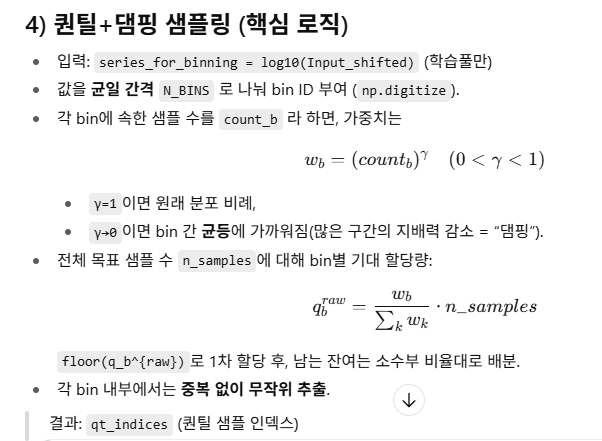

In [20]:
import os
import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# ───────────────────────── 설정 ─────────────────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_quantile_sampling_results_log10")
SEED = 42                       # 홀드아웃 분할 시드
TRAIN_RATIO = 0.80              # 80% 학습풀
QT_FRAC = 0.40                  # 전체의 40%: quantile+damping
RD_FRAC = 0.40                  # 전체의 40%: random
N_RUNS = 5
N_BINS = 10                     # 균일 구간(bin) 개수 (log10(Input_shifted)에 대해)
DAMPING_GAMMA = 0.5             # 감쇠(0<γ<1). γ↓ → 균등에 가까움
N_ESTIMATORS = 800
MAX_DEPTH = None
N_JOBS = -1
RANDOM_STATE = 52               # RF 내부 시드

OUTDIR.mkdir(parents=True, exist_ok=True)

# 로그 설정
log_path = OUTDIR / f"train_quantile_sampling_log10_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("RF_QS_LOG10")

logger.info("===== RF + Quantile-weighted sampling on log10(Input_shifted) =====")
logger.info(f"DATA_PATH      : {DATA_PATH}")
logger.info(f"TRAIN_RATIO    : {TRAIN_RATIO} (holdout {1-TRAIN_RATIO:.2f})")
logger.info(f"QT/RD FRAC     : {QT_FRAC:.2f} / {RD_FRAC:.2f} (of TOTAL)")
logger.info(f"N_BINS / GAMMA : {N_BINS} / {DAMPING_GAMMA}")
logger.info(f"RF params      : n_estimators={N_ESTIMATORS}, max_depth={MAX_DEPTH}, n_jobs={N_JOBS}")

# ───────────────────── 데이터 로드 & 피처 선택 ─────────────────────
df = pd.read_csv(DATA_PATH)

FEATURES = [
    "LCD", "PLD", "LFPD", "cm3_g", "ASA_m2_cm3", "ASA_m2_g",
    "NASA_m2_cm3", "NASA_m2_g", "AV_VF", "AV_cm3_g", "NAV_cm3_g", "Has_OMS", "Input"
]
META_KEEP = ["filename", "name"]
TARGET = "Output"

missing_cols = [c for c in FEATURES + META_KEEP + [TARGET] if c not in df.columns]
if missing_cols:
    raise KeyError(f"Dataset missing columns: {missing_cols}")

# Has_OMS 정규화
if df["Has_OMS"].dtype == bool:
    df["Has_OMS"] = df["Has_OMS"].astype(int)
elif not np.issubdtype(df["Has_OMS"].dtype, np.number):
    df["Has_OMS"] = df["Has_OMS"].astype(str).str.lower().map({"true":1, "false":0}).fillna(0).astype(int)

# NaN 제거
before = len(df)
df = df.dropna(subset=FEATURES + [TARGET]).copy()
after = len(df)
logger.info(f"Drop NaN rows (FEATURES+TARGET): {before} -> {after}")

# ───────────────────── log10 정규화용 shift ─────────────────────
# Input이 0 이하 포함 시 전역 shift로 모두 양수화: x_shifted = x - min(x) + eps
inp = pd.to_numeric(df["Input"], errors="coerce")
if inp.isna().any():
    raise ValueError("Input 열에 숫자로 변환 불가 값이 있습니다.")
min_val = float(inp.min())
eps = 1e-12
shift = -min_val + eps if min_val <= 0 else 0.0
df["Input_shifted"] = inp + shift
df["Input_log10"] = np.log10(df["Input_shifted"])
logger.info(f"Input shift used: {shift:.3e} (min before={min_val:.6g})")

# ───────────────────── Holdout split (고정) ─────────────────────
X = df[FEATURES].copy()                 # 학습 피처는 원본 스케일 유지
y = df[TARGET].astype(float).copy()
meta = df[META_KEEP].copy()
log_s = df["Input_log10"]               # 샘플링용 시리즈

X_train_pool, X_test, y_train_pool, y_test, meta_train_pool, meta_test, log_train_pool, log_test = train_test_split(
    X, y, meta, log_s, test_size=1-TRAIN_RATIO, random_state=SEED, shuffle=True
)

N_total = len(df)
N_qt_target = int(round(QT_FRAC * N_total))
N_rd_target = int(round(RD_FRAC * N_total))

# 학습풀에서 뽑을 수 있는 최대치 고려(안전 보정)
max_from_pool = len(X_train_pool)
if N_qt_target + N_rd_target > max_from_pool:
    scale = max_from_pool / max(1, (N_qt_target + N_rd_target))
    N_qt = int(np.floor(N_qt_target * scale))
    N_rd = int(np.floor(N_rd_target * scale))
    if N_qt + N_rd < max_from_pool:
        N_qt += 1
else:
    N_qt, N_rd = N_qt_target, N_rd_target

logger.info(f"Total={N_total} | Train pool={len(X_train_pool)} | Test holdout={len(X_test)}")
logger.info(f"Target subset sizes from TRAIN POOL: QT={N_qt}, RD={N_rd}")

# ───────────────────── 샘플링 함수 ─────────────────────
def quantile_weighted_sample(series_for_binning: pd.Series, n_bins: int, gamma: float,
                             n_samples: int, seed: int) -> np.ndarray:
    """
    series_for_binning: log10(Input_shifted) 같은 1D 시리즈
    균일 간격 n_bins로 나눠 count^gamma 비례로 quota 배정 후 bin 내 uniform 추출
    """
    rng = np.random.default_rng(seed)
    vals = series_for_binning.values.astype(float)
    idx = series_for_binning.index.values

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        return rng.choice(idx, size=min(n_samples, len(idx)), replace=False)

    edges = np.linspace(vmin, vmax, n_bins + 1)
    bin_ids = np.digitize(vals, edges, right=False) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    bin_to_idx = {b: idx[bin_ids == b] for b in range(n_bins)}
    counts = np.array([len(bin_to_idx[b]) for b in range(n_bins)], dtype=float)

    valid_bins = np.where(counts > 0)[0]
    if len(valid_bins) == 0:
        raise RuntimeError("No non-empty bins for sampling series.")

    weights = np.zeros_like(counts)
    weights[valid_bins] = counts[valid_bins] ** gamma
    wsum = weights[valid_bins].sum()
    probs = weights / (wsum if wsum > 0 else 1.0)

    raw_quota = probs * n_samples
    quota = np.floor(raw_quota).astype(int)
    deficit = n_samples - int(quota.sum())
    if deficit > 0:
        frac = raw_quota - quota
        fsum = frac.sum()
        if fsum > 0:
            add_bins = rng.choice(np.arange(n_bins), size=deficit, replace=True, p=frac / fsum)
        else:
            add_bins = rng.choice(valid_bins, size=deficit, replace=True)
        for b in add_bins:
            quota[b] += 1

    selected = []
    for b in range(n_bins):
        k = int(quota[b])
        if k <= 0: 
            continue
        pool = bin_to_idx.get(b, np.array([], dtype=idx.dtype))
        if len(pool) == 0:
            continue
        k = min(k, len(pool))
        chosen = rng.choice(pool, size=k, replace=False)
        selected.append(chosen)

    if not selected:
        return np.array([], dtype=idx.dtype)
    sel = np.concatenate(selected)

    # 과다/과소 보정
    if len(sel) > n_samples:
        sel = sel[:n_samples]
    elif len(sel) < n_samples:
        remain = np.setdiff1d(idx, sel, assume_unique=False)
        if len(remain) > 0:
            add = rng.choice(remain, size=min(n_samples - len(sel), len(remain)), replace=False)
            sel = np.concatenate([sel, add])
    return sel

# ───────────────────── 5 runs ─────────────────────
metrics_all = []
for run in range(1, N_RUNS + 1):
    quant_seed = 1000 + run
    rand_seed  = 2000 + run

    # log10(Input_shifted)에 대해 quantile+damping 샘플링
    qt_indices = quantile_weighted_sample(
        log_train_pool, n_bins=N_BINS, gamma=DAMPING_GAMMA, n_samples=N_qt, seed=quant_seed
    )

    # 남은 학습풀에서 랜덤샘플링
    pool_idx = X_train_pool.index.values
    remain_idx = np.setdiff1d(pool_idx, qt_indices, assume_unique=False)
    rng = np.random.default_rng(rand_seed)
    rd_pick = min(N_rd, len(remain_idx))
    rd_indices = rng.choice(remain_idx, size=rd_pick, replace=False)

    # 최종 학습셋
    train_idx = np.concatenate([qt_indices, rd_indices])
    X_tr = X_train_pool.loc[train_idx]
    y_tr = y_train_pool.loc[train_idx]
    X_te = X_test
    y_te = y_test
    meta_te_run = meta_test.reset_index(drop=True)

    logger.info(f"[Run {run}] QT={len(qt_indices)} | RD={len(rd_indices)} | Train={len(train_idx)} | Test={len(X_te)}")

    # ── (선택) 학습/평가 블록: 필요 없으면 주석 처리 가능 ──
    rf = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE
    )
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)

    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = mean_squared_error(y_te, y_pred)  # RMSE 정확히 계산
    mape = (np.abs((y_te - y_pred) / np.clip(np.abs(y_te), 1e-12, None))).mean() * 100.0

    logger.info(f"[Run {run}] R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f} | MAPE%={mape:.3f}")

    metrics_all.append({
        "run": run,
        "R2": r2, "MAE": mae, "RMSE": rmse, "MAPE_percent": mape,
        "n_train": len(train_idx), "n_test": len(X_te),
        "quant_seed": quant_seed, "rand_seed": rand_seed,
        "N_bins": N_BINS, "gamma": DAMPING_GAMMA, "shift": shift
    })

    # 선택 사항: 예측 결과/선택 인덱스 저장
    pred_df = pd.concat([meta_te_run, X_te.reset_index(drop=True)], axis=1)
    pred_df["y_true"] = y_te.values
    pred_df["y_pred"] = y_pred
    pred_df.to_csv(OUTDIR / f"predictions_run{run}.csv", index=False, encoding="utf-8-sig")

    pd.DataFrame({"qt_indices": pd.Series(qt_indices),
                  "rd_indices": pd.Series(rd_indices)}).to_csv(
        OUTDIR / f"selected_indices_run{run}.csv", index=False, encoding="utf-8-sig"
    )

# 메트릭 저장
metrics_df = pd.DataFrame(metrics_all)
metrics_df.loc["mean"] = {
    "run": "mean",
    "R2": metrics_df["R2"].mean(),
    "MAE": metrics_df["MAE"].mean(),
    "RMSE": metrics_df["RMSE"].mean(),
    "MAPE_percent": metrics_df["MAPE_percent"].mean(),
    "n_train": metrics_df["n_train"].mean(),
    "n_test": metrics_df["n_test"].mean(),
    "quant_seed": np.nan, "rand_seed": np.nan,
    "N_bins": N_BINS, "gamma": DAMPING_GAMMA, "shift": shift
}
metrics_df.to_csv(OUTDIR / "metrics_runs.csv", index=False, encoding="utf-8-sig")
logger.info(f"Saved metrics: {OUTDIR / 'metrics_runs.csv'}")

logger.info("===== Done. Quantile-weighted sampling on log10(Input_shifted). =====")


2025-09-06 21:37:34,580 | INFO | ===== RF + Quantile-weighted sampling on log10(Input_shifted) =====
2025-09-06 21:37:34,582 | INFO | DATA_PATH      : ../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv
2025-09-06 21:37:34,583 | INFO | TRAIN_RATIO    : 0.8 (holdout 0.20)
2025-09-06 21:37:34,584 | INFO | QT/RD FRAC     : 0.40 / 0.40 (of TOTAL)
2025-09-06 21:37:34,586 | INFO | N_BINS / GAMMA : 10 / 0.5
2025-09-06 21:37:34,586 | INFO | RF params      : n_estimators=800, max_depth=None, n_jobs=-1
2025-09-06 21:37:34,645 | INFO | Drop NaN rows (FEATURES+TARGET): 7766 -> 7766
2025-09-06 21:37:34,653 | INFO | Input shift used: 0.000e+00 (min before=0.000123193)
2025-09-06 21:37:34,681 | INFO | Total=7766 | Train pool=6212 | Test holdout=1554
2025-09-06 21:37:34,683 | INFO | Target subset sizes from TRAIN POOL: QT=3106, RD=3106
2025-09-06 21:37:34,699 | INFO | [Run 1] QT=3106 | RD=3106 | Train=6212 | Test=1554
2025-09-06 21:37:41,352 | INFO | [Run 1] R2=0.937431 | MAE=

2025-09-06 21:32:38,544 | DEBUG | vmin 7.36036351292479e-05 vmax 6.137735227676505
2025-09-06 21:32:38,547 | DEBUG | ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02])
2025-09-06 21:32:38,559 | DEBUG | vmin 7.36036351292479e-05 vmax 6.137735227676505
2025-09-06 21:32:38,561 | DEBUG | ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
2025-09-06 21:32:38,5

(array([  1.,   1.,   2.,   0.,   1.,   2.,   2.,   2.,   4.,   3.,   6.,
          4.,  12.,   9.,   8.,  19.,  21.,  21.,  33.,  45.,  32.,  41.,
         71.,  73.,  97., 115., 100., 136., 176., 222., 266., 293., 279.,
        416., 436., 430., 499., 504., 457., 458., 452., 355., 303., 265.,
        203., 171., 140.,  96.,  89.,  48.,  50.,  29.,  48.,  21.,  17.,
         13.,  12.,  10.,  11.,   9.,   8.,  11.,  11.,   6.,   7.,   6.,
          4.,   9.,   4.,   4.,   4.,   9.,   7.,   6.,  12.,   4.,   0.,
          2.,   1.,   1.,   2.,   3.,   2.,   0.,   0.,   0.,   0.,   2.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-3.90941397, -3.86467662, -3.81993926, -3.77520191, -3.73046455,
        -3.6857272 , -3.64098985, -3.59625249, -3.55151514, -3.50677779,
        -3.46204043, -3.41730308, -3.37256573, -3.32782837, -3.28309102,
        -3.23835367, -3.19361631, -3.14887896, -3.10414161, -3.05940425,
        -3.0146669 , -2.96

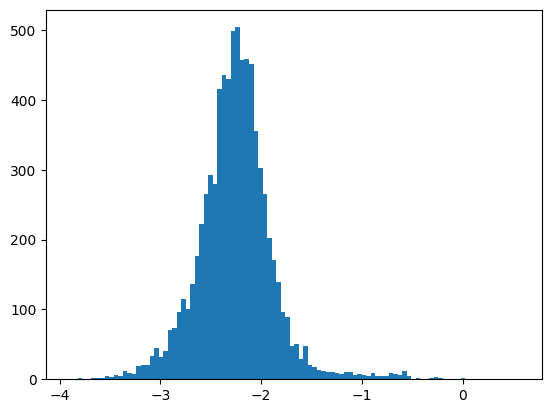

In [ ]:
plt.hist(np.log10(df["Input"].values), bins = 100)

## Input 열을 히스토그램으로 시각화

In [25]:
# -*- coding: utf-8 -*-
"""
전체에서 바로:
- Quantile+damping 40% (Input 로그 스페이스 기준)
- 남은 것 중 Random 40%
- 나머지 20% = Test
으로 샘플링하고, log10(Input) 기준 bins=100 스택 히스토그램(Quantile/Random/Test)을 그림.
"""

import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ───────────── 설정 ─────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_sampling_STACK_log10_QT40_RD40_TE20")
OUTDIR.mkdir(parents=True, exist_ok=True)

QT_FRAC = 0.40          # 전체의 40%: Quantile+damping
RD_FRAC = 0.40          # 전체의 40%: Random (Quantile 제외하고)
TE_FRAC = 0.20          # 나머지 20%: Test (자동 계산되지만 표기용)
N_BINS_UNIFORM = 10     # Quantile 샘플링용 구간 수 (log10(Input_shifted) 공간)
DAMPING_GAMMA = 0.5     # 감쇠(0<γ<1). γ↓ → 균등에 가까움
SEED_QT = 123           # Quantile 샘플링 시드
SEED_RD = 456           # Random 샘플링 시드
PLOT_BINS = 100         # 히스토그램 bin 개수

# ───────────── 로깅 ─────────────
log_path = OUTDIR / f"sampling_QT40_RD40_TE20_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("SAMPLING_QR_T")

# ───────────── 함수: quantile+damping 샘플링 ─────────────
def quantile_weighted_sample(series_for_binning: pd.Series,
                             n_bins: int,
                             gamma: float,
                             n_samples: int,
                             seed: int) -> np.ndarray:
    """
    series_for_binning (예: log10(Input_shifted))을 균일 간격 n_bins로 나누고,
    각 bin의 count^gamma 비례로 quota를 배정한 뒤 bin 내에서 without-replacement 추출.
    반환: 선택된 row index (np.ndarray)
    """
    rng = np.random.default_rng(seed)
    vals = series_for_binning.values.astype(float)
    idx  = series_for_binning.index.values

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        # 전부 같은 값이면 그냥 무작위 선택
        return rng.choice(idx, size=min(n_samples, len(idx)), replace=False)

    edges   = np.linspace(vmin, vmax, n_bins + 1)
    bin_ids = np.digitize(vals, edges, right=False) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    bin_to_idx = {b: idx[bin_ids == b] for b in range(n_bins)}
    counts     = np.array([len(bin_to_idx[b]) for b in range(n_bins)], dtype=float)

    valid_bins = np.where(counts > 0)[0]
    if len(valid_bins) == 0:
        raise RuntimeError("No non-empty bins for sampling series.")

    # 가중치: count^gamma
    weights = np.zeros_like(counts)
    weights[valid_bins] = counts[valid_bins] ** gamma
    wsum = weights[valid_bins].sum()
    probs = weights / (wsum if wsum > 0 else 1.0)

    # 기대 할당량 → 정수 quota
    raw_quota = probs * n_samples
    quota     = np.floor(raw_quota).astype(int)
    deficit   = int(n_samples - quota.sum())
    if deficit > 0:
        frac = raw_quota - quota
        fsum = frac.sum()
        if fsum > 0:
            add_bins = rng.choice(np.arange(n_bins), size=deficit, replace=True, p=frac / fsum)
        else:
            add_bins = rng.choice(valid_bins, size=deficit, replace=True)
        for b in add_bins:
            quota[b] += 1

    # bin 내 without-replacement
    selected = []
    for b in range(n_bins):
        k = int(quota[b])
        if k <= 0: 
            continue
        pool = bin_to_idx.get(b, np.array([], dtype=idx.dtype))
        if len(pool) == 0:
            continue
        k = min(k, len(pool))
        chosen = rng.choice(pool, size=k, replace=False)
        selected.append(chosen)

    if not selected:
        return np.array([], dtype=idx.dtype)

    sel = np.concatenate(selected)

    # 과다/과소 보정
    if len(sel) > n_samples:
        sel = sel[:n_samples]
    elif len(sel) < n_samples:
        remain = np.setdiff1d(idx, sel, assume_unique=False)
        if len(remain) > 0:
            add = rng.choice(remain, size=min(n_samples - len(sel), len(remain)), replace=False)
            sel = np.concatenate([sel, add])
    return sel

# ───────────── 메인 ─────────────
def main():
    # 데이터 로드 및 전처리
    df = pd.read_csv(DATA_PATH)
    if "Input" not in df.columns:
        raise KeyError("Dataset must contain 'Input' column.")

    df = df.copy()
    df["Input"] = pd.to_numeric(df["Input"], errors="coerce")
    df = df.dropna(subset=["Input"])
    logger.info(f"Rows after cleaning: {len(df)}")

    # log10(Input) 위한 shift
    eps = 1e-12
    min_in = float(df["Input"].min())
    shift_in = -min_in + eps if min_in <= 0 else 0.0
    df["Input_shifted"] = df["Input"] + shift_in
    df["Input_log10"]   = np.log10(df["Input_shifted"])
    logger.info(f"shift_in={shift_in:.3e} (min Input before shift={min_in:.6g})")

    # 전체에서 바로 목표 수량 계산 (반올림으로 총합 맞춤)
    N_total = len(df)
    N_qt = int(round(QT_FRAC * N_total))
    N_rd = int(round(RD_FRAC * N_total))
    # 반올림 오차 보정: Test는 나머지 전부
    if N_qt + N_rd > N_total:
        # 드물지만 반올림으로 넘치면 RD를 줄임
        N_rd = N_total - N_qt
    N_te = N_total - (N_qt + N_rd)

    logger.info(f"N_total={N_total} | N_qt={N_qt} | N_rd={N_rd} | N_te={N_te} (QT40/RD40/TE20 목표)")

    # 1) Quantile+damping 40% (전 데이터 대상)
    qt_indices = quantile_weighted_sample(
        df["Input_log10"], n_bins=N_BINS_UNIFORM, gamma=DAMPING_GAMMA,
        n_samples=N_qt, seed=SEED_QT
    )

    # 2) 남은 것 중에서 Random 40%
    all_idx = df.index.values
    remain_after_qt = np.setdiff1d(all_idx, qt_indices, assume_unique=False)
    rng = np.random.default_rng(SEED_RD)
    rd_pick = min(N_rd, len(remain_after_qt))
    rd_indices = rng.choice(remain_after_qt, size=rd_pick, replace=False)

    # 3) 나머지 전부 Test
    remain_after_qt_rd = np.setdiff1d(remain_after_qt, rd_indices, assume_unique=False)
    te_indices = remain_after_qt_rd  # 길이가 자동으로 N_te가 됨

    logger.info(f"Selected sizes | QT={len(qt_indices)} | RD={len(rd_indices)} | TE={len(te_indices)}")

    # ── 스택 히스토그램 (log10(Input+shift) 기준, 100 bins)
    all_log = df.loc[all_idx, "Input_log10"].values
    qt_log  = df.loc[qt_indices, "Input_log10"].values
    rd_log  = df.loc[rd_indices, "Input_log10"].values
    te_log  = df.loc[te_indices, "Input_log10"].values

    edges = np.linspace(all_log.min(), all_log.max(), PLOT_BINS + 1)
    cnt_all, _ = np.histogram(all_log, bins=edges)
    cnt_qt,  _ = np.histogram(qt_log,  bins=edges)
    cnt_rd,  _ = np.histogram(rd_log,  bins=edges)
    cnt_te,  _ = np.histogram(te_log,  bins=edges)

    centers = (edges[:-1] + edges[1:]) / 2.0
    width   = np.diff(edges)

    plt.figure(figsize=(11, 6))
    plt.step(edges[:-1], cnt_all, where="post", linewidth=1.8,
             label=f"All (N={len(all_log)})", color="black")

    bottom = np.zeros_like(cnt_te, dtype=float)
    # 아래에서부터 Test → Random → Quantile 순서로 쌓기 (가독성)
    plt.bar(centers, cnt_te, width=width, label=f"Test (N={len(te_log)})", alpha=0.8)
    bottom += cnt_te
    plt.bar(centers, cnt_rd, width=width, bottom=bottom, label=f"Random (N={len(rd_log)})", alpha=0.8)
    bottom += cnt_rd
    plt.bar(centers, cnt_qt, width=width, bottom=bottom, label=f"Quantile+damping (N={len(qt_log)})", alpha=0.8)

    plt.xlabel("log10(Input + shift_in)")
    plt.ylabel("Count")
    plt.title(
        f"Stacked histogram on log10(Input), bins={PLOT_BINS}\n"
        f"(QT={QT_FRAC:.0%}, RD={RD_FRAC:.0%}, TE≈{TE_FRAC:.0%}, "
        f"shift_in={shift_in:.3e}, bins_for_sampling={N_BINS_UNIFORM}, gamma={DAMPING_GAMMA})"
    )
    plt.legend()
    plt.tight_layout()

    fig_path = OUTDIR / f"stack_log10_Input_QT40_RD40_TE20_bins{PLOT_BINS}_seed{SEED_QT}_{SEED_RD}.png"
    plt.savefig(fig_path, dpi=200)
    plt.close()
    logger.info(f"Saved stacked histogram → {fig_path}")

    # bin별 카운트 CSV
    hist_df = pd.DataFrame({
        "bin_left_log10": edges[:-1],
        "bin_right_log10": edges[1:],
        "count_all": cnt_all,
        "count_test": cnt_te,
        "count_random": cnt_rd,
        "count_quantile": cnt_qt
    })
    hist_csv = OUTDIR / f"hist_counts_QT40_RD40_TE20_bins{PLOT_BINS}_seed{SEED_QT}_{SEED_RD}.csv"
    hist_df.to_csv(hist_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved histogram counts → {hist_csv}")

    # 선택 인덱스 CSV (재현성 확인)
    idx_csv = OUTDIR / f"indices_QT_RD_TE_seed{SEED_QT}_{SEED_RD}.csv"
    pd.DataFrame({
        "qt_indices": pd.Series(qt_indices),
        "rd_indices": pd.Series(rd_indices),
        "te_indices": pd.Series(te_indices)
    }).to_csv(idx_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved indices → {idx_csv}")

if __name__ == "__main__":
    main()


2025-09-06 21:57:57,246 | INFO | Rows after cleaning: 7766
2025-09-06 21:57:57,249 | INFO | shift_in=0.000e+00 (min Input before shift=0.000123193)
2025-09-06 21:57:57,250 | INFO | N_total=7766 | N_qt=3106 | N_rd=3106 | N_te=1554 (QT40/RD40/TE20 목표)
2025-09-06 21:57:57,255 | INFO | Selected sizes | QT=3106 | RD=3106 | TE=1554
2025-09-06 21:57:57,874 | INFO | Saved stacked histogram → RF_Ar273K_sampling_STACK_log10_QT40_RD40_TE20\stack_log10_Input_QT40_RD40_TE20_bins100_seed123_456.png
2025-09-06 21:57:57,878 | INFO | Saved histogram counts → RF_Ar273K_sampling_STACK_log10_QT40_RD40_TE20\hist_counts_QT40_RD40_TE20_bins100_seed123_456.csv
2025-09-06 21:57:57,885 | INFO | Saved indices → RF_Ar273K_sampling_STACK_log10_QT40_RD40_TE20\indices_QT_RD_TE_seed123_456.csv


## Output으로 히스토그램 (x축 로그 x)

In [ ]:
# -*- coding: utf-8 -*-
"""
Input(log10, shifted) 기반으로
- Holdout 20% (Test)
- Train pool(80%) 중 Quantile+damping 40%
- Train pool(80%) 중 Random 40%
을 한 번의 시드로 샘플링하고,
이번에는 'Output' 값으로 bins=100 스택 히스토그램을 그림.
"""

import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ───────────── 설정 ─────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_sampling_stack_OUTPUT_one_seed")
OUTDIR.mkdir(parents=True, exist_ok=True)

SEED_HOLDOUT = 42      # 학습풀/테스트 분리 시드
TRAIN_RATIO  = 0.80    # 80% 학습풀
QT_FRAC      = 0.40    # 전체의 40%: Quantile+damping
RD_FRAC      = 0.40    # 전체의 40%: Random
N_BINS_UNIFORM = 10    # 퀀틸 샘플링용 bin 개수 (log10(Input_shifted) 공간에서)
DAMPING_GAMMA  = 0.5   # 감쇠 지수(0<γ<1)
SEED_QT = 123          # quantile 샘플링 시드
SEED_RD = 456          # 랜덤 샘플링 시드

# 플롯 bin 개수 (요청: 100)
PLOT_BINS = 100

# ───────────── 로깅 ─────────────
log_path = OUTDIR / f"sampling_ONLY_OUTPUT_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("SAMPLING_OUTPUT")

# ───────────── 함수: quantile+damping 샘플링 ─────────────
def quantile_weighted_sample(series_for_binning: pd.Series,
                             n_bins: int,
                             gamma: float,
                             n_samples: int,
                             seed: int) -> np.ndarray:
    """
    series_for_binning (예: log10(Input_shifted))을 균일 간격 n_bins로 나누고,
    각 bin의 count^gamma 비례로 quota를 배정, bin 내에서 중복 없이 무작위 추출.
    반환: 선택된 row index (np.ndarray)
    """
    rng = np.random.default_rng(seed)
    vals = series_for_binning.values.astype(float)
    idx  = series_for_binning.index.values

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        # 전부 같은 값이면 그냥 무작위 선택
        return rng.choice(idx, size=min(n_samples, len(idx)), replace=False)

    edges   = np.linspace(vmin, vmax, n_bins + 1)
    bin_ids = np.digitize(vals, edges, right=False) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    bin_to_idx = {b: idx[bin_ids == b] for b in range(n_bins)}
    counts     = np.array([len(bin_to_idx[b]) for b in range(n_bins)], dtype=float)

    valid_bins = np.where(counts > 0)[0]
    if len(valid_bins) == 0:
        raise RuntimeError("No non-empty bins for sampling series.")

    weights = np.zeros_like(counts)
    weights[valid_bins] = counts[valid_bins] ** gamma
    wsum = weights[valid_bins].sum()
    probs = weights / (wsum if wsum > 0 else 1.0)

    raw_quota = probs * n_samples
    quota     = np.floor(raw_quota).astype(int)

    deficit = int(n_samples - quota.sum())
    if deficit > 0:
        frac = raw_quota - quota
        fsum = frac.sum()
        if fsum > 0:
            add_bins = rng.choice(np.arange(n_bins), size=deficit, replace=True, p=frac / fsum)
        else:
            add_bins = rng.choice(valid_bins, size=deficit, replace=True)
        for b in add_bins:
            quota[b] += 1

    selected = []
    for b in range(n_bins):
        k = int(quota[b])
        if k <= 0:
            continue
        pool = bin_to_idx.get(b, np.array([], dtype=idx.dtype))
        if len(pool) == 0:
            continue
        k = min(k, len(pool))
        chosen = rng.choice(pool, size=k, replace=False)
        selected.append(chosen)

    if not selected:
        return np.array([], dtype=idx.dtype)
    sel = np.concatenate(selected)

    # 과다/과소 보정
    if len(sel) > n_samples:
        sel = sel[:n_samples]
    elif len(sel) < n_samples:
        remain = np.setdiff1d(idx, sel, assume_unique=False)
        if len(remain) > 0:
            add = rng.choice(remain, size=min(n_samples - len(sel), len(remain)), replace=False)
            sel = np.concatenate([sel, add])
    return sel

# ───────────── 메인: 샘플링 & Output 스택 히스토그램 ─────────────
def main():
    # 데이터 로드
    df = pd.read_csv(DATA_PATH)

    # 숫자화 및 NaN 제거 (Output까지 포함해서 결측 제거)
    must_have = ["Input", "Output"]
    for c in must_have:
        if c not in df.columns:
            raise KeyError(f"Dataset must contain '{c}' column.")
    df = df.copy()
    df["Input"]  = pd.to_numeric(df["Input"],  errors="coerce")
    df["Output"] = pd.to_numeric(df["Output"], errors="coerce")
    df = df.dropna(subset=must_have)

    # log10을 위한 shift (0 이하 값 대비) -> 샘플링에만 사용
    min_val = float(df["Input"].min())
    eps  = 1e-12
    shift = -min_val + eps if min_val <= 0 else 0.0
    df["Input_shifted"] = df["Input"] + shift
    df["Input_log10"]   = np.log10(df["Input_shifted"])

    logger.info(f"Rows after cleaning: {len(df)} | shift applied: {shift:.3e} | min(Input) before={min_val:.6g}")

    # Holdout split (고정)
    X_log = df[["Input_log10"]].copy()
    y_all = df["Output"].copy()

    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_log, y_all, test_size=1-TRAIN_RATIO, random_state=SEED_HOLDOUT, shuffle=True
    )

    # 목표 수량(전체 대비 40%/40%) → 학습풀 한도로 보정
    N_total     = len(df)
    N_qt_target = int(round(QT_FRAC * N_total))
    N_rd_target = int(round(RD_FRAC * N_total))
    max_from_pool = len(X_train_pool)

    if N_qt_target + N_rd_target > max_from_pool:
        scale = max_from_pool / max(1, (N_qt_target + N_rd_target))
        N_qt = int(np.floor(N_qt_target * scale))
        N_rd = int(np.floor(N_rd_target * scale))
        if N_qt + N_rd < max_from_pool:
            N_qt += 1
    else:
        N_qt, N_rd = N_qt_target, N_rd_target

    logger.info(f"Total={N_total} | Train pool={len(X_train_pool)} | Test={len(X_test)} | QT={N_qt} | RD={N_rd}")

    # Quantile+damping 샘플링 (log 스페이스에서 균일 bin)
    qt_indices = quantile_weighted_sample(
        X_train_pool["Input_log10"], n_bins=N_BINS_UNIFORM, gamma=DAMPING_GAMMA,
        n_samples=N_qt, seed=SEED_QT
    )

    # 남은 학습풀에서 랜덤샘플링
    pool_idx   = X_train_pool.index.values
    remain_idx = np.setdiff1d(pool_idx, qt_indices, assume_unique=False)
    rng = np.random.default_rng(SEED_RD)
    rd_pick = min(N_rd, len(remain_idx))
    rd_indices = rng.choice(remain_idx, size=rd_pick, replace=False)

    logger.info(f"Selected | Quantile={len(qt_indices)} | Random={len(rd_indices)} | Test={len(X_test)}")

    # ── Output 값 수집 (스택 히스토그램은 Output으로)
    all_out = y_all.values
    qt_out  = y_train_pool.loc[qt_indices].values
    rd_out  = y_train_pool.loc[rd_indices].values
    te_out  = y_test.values

    # 공통 bin 경계 (Output 전체 범위, bins=100)
    edges = np.linspace(all_out.min(), all_out.max(), PLOT_BINS + 1)

    # 그룹별 히스토그램 카운트
    cnt_all, _ = np.histogram(all_out, bins=edges)
    cnt_te,  _ = np.histogram(te_out,  bins=edges)
    cnt_rd,  _ = np.histogram(rd_out,  bins=edges)
    cnt_qt,  _ = np.histogram(qt_out,  bins=edges)

    # 스택 막대 그리기
    centers = (edges[:-1] + edges[1:]) / 2.0
    width   = np.diff(edges)

    plt.figure(figsize=(11, 6))
    # 전체 Output 분포 윤곽선(참고)
    plt.step(edges[:-1], cnt_all, where="post", linewidth=1.8, label=f"All Output (N={len(all_out)})", color="black")

    # 스택: 아래에서부터 Test → Random → Quantile
    bottom = np.zeros_like(cnt_te, dtype=float)
    plt.bar(centers, cnt_te, width=width, label=f"Test (N={len(te_out)})", alpha=0.8)
    bottom += cnt_te
    plt.bar(centers, cnt_rd, width=width, bottom=bottom, label=f"Random (N={len(rd_out)})", alpha=0.8)
    bottom += cnt_rd
    plt.bar(centers, cnt_qt, width=width, bottom=bottom, label=f"Quantile+damping (N={len(qt_out)})", alpha=0.8)

    plt.xlabel("Output")
    plt.ylabel("Count")
    plt.title(f"Stacked histogram on Output (sampling by log10(Input)), bins={PLOT_BINS}\n"
              f"(shift={shift:.3e}, bins_for_sampling={N_BINS_UNIFORM}, gamma={DAMPING_GAMMA})")
    plt.legend()
    plt.tight_layout()

    fig_path = OUTDIR / f"sampling_STACK_OUTPUT_bins{PLOT_BINS}_seed{SEED_QT}_{SEED_RD}.png"
    plt.savefig(fig_path, dpi=200)
    plt.close()
    logger.info(f"Saved stacked histogram (Output) → {fig_path}")

    # ── bin별 카운트 테이블 저장
    hist_df = pd.DataFrame({
        "bin_left": edges[:-1],
        "bin_right": edges[1:],
        "count_all": cnt_all,
        "count_test": cnt_te,
        "count_random": cnt_rd,
        "count_quantile": cnt_qt
    })
    hist_csv = OUTDIR / f"sampling_hist_OUTPUT_counts_bins{PLOT_BINS}_seed{SEED_QT}_{SEED_RD}.csv"
    hist_df.to_csv(hist_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved histogram counts (Output) → {hist_csv}")

    # 선택 인덱스 저장(재현성 체크용)
    sel_idx_csv = OUTDIR / f"selected_indices_seed{SEED_QT}_{SEED_RD}.csv"
    pd.DataFrame({"qt_indices": pd.Series(qt_indices),
                  "rd_indices": pd.Series(rd_indices)}).to_csv(sel_idx_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved indices → {sel_idx_csv}")

if __name__ == "__main__":
    main()


2025-09-06 21:47:17,441 | INFO | Rows after cleaning: 7766 | shift applied: 0.000e+00 | min(Input) before=0.000123193
2025-09-06 21:47:17,444 | INFO | Total=7766 | Train pool=6212 | Test=1554 | QT=3106 | RD=3106
2025-09-06 21:47:17,447 | INFO | Selected | Quantile=3106 | Random=3106 | Test=1554
2025-09-06 21:47:18,057 | INFO | Saved stacked histogram (Output) → RF_Ar273K_sampling_stack_OUTPUT_one_seed\sampling_STACK_OUTPUT_bins100_seed123_456.png
2025-09-06 21:47:18,061 | INFO | Saved histogram counts (Output) → RF_Ar273K_sampling_stack_OUTPUT_one_seed\sampling_hist_OUTPUT_counts_bins100_seed123_456.csv
2025-09-06 21:47:18,066 | INFO | Saved indices → RF_Ar273K_sampling_stack_OUTPUT_one_seed\selected_indices_seed123_456.csv


## Output으로 히스토그램 (X축 로그10)

In [23]:
# -*- coding: utf-8 -*-
"""
Input(log10, shifted) 기반으로
- Holdout 20% (Test)
- Train pool(80%) 중 Quantile+damping 40%
- Train pool(80%) 중 Random 40%
을 한 번의 시드로 샘플링하고,
'Output'을 log10(shifted)로 변환해 bins=100 스택 히스토그램을 그림.
(학습 없음, 샘플링/시각화/카운트 CSV 저장만 수행)
"""
import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ───────────── 설정 ─────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_sampling_stack_OUTPUT_LOG_one_seed")
OUTDIR.mkdir(parents=True, exist_ok=True)

SEED_HOLDOUT = 42      # 학습풀/테스트 분리 시드
TRAIN_RATIO  = 0.80    # 80% 학습풀
QT_FRAC      = 0.40    # 전체의 40%: Quantile+damping
RD_FRAC      = 0.40    # 전체의 40%: Random
N_BINS_UNIFORM = 10    # 퀀틸 샘플링용 bin 개수 (log10(Input_shifted) 공간에서)
DAMPING_GAMMA  = 0.5   # 감쇠 지수(0<γ<1)
SEED_QT = 123          # quantile 샘플링 시드
SEED_RD = 456          # 랜덤 샘플링 시드

# 플롯 bin 개수 (요청: 100)
PLOT_BINS = 100

# ───────────── 로깅 ─────────────
log_path = OUTDIR / f"sampling_ONLY_OUTPUT_LOG_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("SAMPLING_OUTPUT_LOG")

# ───────────── 함수: quantile+damping 샘플링 ─────────────
def quantile_weighted_sample(series_for_binning: pd.Series,
                             n_bins: int,
                             gamma: float,
                             n_samples: int,
                             seed: int) -> np.ndarray:
    """
    series_for_binning (예: log10(Input_shifted))을 균일 간격 n_bins로 나누고,
    각 bin의 count^gamma 비례로 quota를 배정, bin 내에서 중복 없이 무작위 추출.
    반환: 선택된 row index (np.ndarray)
    """
    rng = np.random.default_rng(seed)
    vals = series_for_binning.values.astype(float)
    idx  = series_for_binning.index.values

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        return rng.choice(idx, size=min(n_samples, len(idx)), replace=False)

    edges   = np.linspace(vmin, vmax, n_bins + 1)
    bin_ids = np.digitize(vals, edges, right=False) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    bin_to_idx = {b: idx[bin_ids == b] for b in range(n_bins)}
    counts     = np.array([len(bin_to_idx[b]) for b in range(n_bins)], dtype=float)

    valid_bins = np.where(counts > 0)[0]
    if len(valid_bins) == 0:
        raise RuntimeError("No non-empty bins for sampling series.")

    weights = np.zeros_like(counts)
    weights[valid_bins] = counts[valid_bins] ** gamma
    wsum = weights[valid_bins].sum()
    probs = weights / (wsum if wsum > 0 else 1.0)

    raw_quota = probs * n_samples
    quota     = np.floor(raw_quota).astype(int)

    deficit = int(n_samples - quota.sum())
    if deficit > 0:
        frac = raw_quota - quota
        fsum = frac.sum()
        if fsum > 0:
            add_bins = rng.choice(np.arange(n_bins), size=deficit, replace=True, p=frac / fsum)
        else:
            add_bins = rng.choice(valid_bins, size=deficit, replace=True)
        for b in add_bins:
            quota[b] += 1

    selected = []
    for b in range(n_bins):
        k = int(quota[b])
        if k <= 0:
            continue
        pool = bin_to_idx.get(b, np.array([], dtype=idx.dtype))
        if len(pool) == 0:
            continue
        k = min(k, len(pool))
        chosen = rng.choice(pool, size=k, replace=False)
        selected.append(chosen)

    if not selected:
        return np.array([], dtype=idx.dtype)
    sel = np.concatenate(selected)

    if len(sel) > n_samples:
        sel = sel[:n_samples]
    elif len(sel) < n_samples:
        remain = np.setdiff1d(idx, sel, assume_unique=False)
        if len(remain) > 0:
            add = rng.choice(remain, size=min(n_samples - len(sel), len(remain)), replace=False)
            sel = np.concatenate([sel, add])
    return sel

# ───────────── 메인: 샘플링 & Output(log10) 스택 히스토그램 ─────────────
def main():
    # 데이터 로드
    df = pd.read_csv(DATA_PATH)

    # 숫자화 및 NaN 제거 (Input, Output 모두 확인)
    must_have = ["Input", "Output"]
    for c in must_have:
        if c not in df.columns:
            raise KeyError(f"Dataset must contain '{c}' column.")
    df = df.copy()
    df["Input"]  = pd.to_numeric(df["Input"],  errors="coerce")
    df["Output"] = pd.to_numeric(df["Output"], errors="coerce")
    df = df.dropna(subset=must_have)

    # ── 샘플링용: log10(Input_shifted)
    min_in = float(df["Input"].min())
    eps = 1e-12
    shift_in = -min_in + eps if min_in <= 0 else 0.0
    df["Input_shifted"] = df["Input"] + shift_in
    df["Input_log10"]   = np.log10(df["Input_shifted"])

    # ── 플로팅용: log10(Output_shifted)
    min_out = float(df["Output"].min())
    shift_out = -min_out + eps if min_out <= 0 else 0.0
    df["Output_shifted"] = df["Output"] + shift_out
    df["Output_log10"]   = np.log10(df["Output_shifted"])

    logger.info(
        f"Rows={len(df)} | shift_in={shift_in:.3e} (min Input={min_in:.6g}) | "
        f"shift_out={shift_out:.3e} (min Output={min_out:.6g})"
    )

    # Holdout split (고정) — 샘플링은 Input_log10으로, 플롯은 Output_log10으로
    X_log_in = df[["Input_log10"]].copy()
    y_log_out = df["Output_log10"].copy()

    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X_log_in, y_log_out, test_size=1-TRAIN_RATIO, random_state=SEED_HOLDOUT, shuffle=True
    )

    # 목표 수량(전체 대비 40%/40%) → 학습풀 한도로 보정
    N_total     = len(df)
    N_qt_target = int(round(QT_FRAC * N_total))
    N_rd_target = int(round(RD_FRAC * N_total))
    max_from_pool = len(X_train_pool)

    if N_qt_target + N_rd_target > max_from_pool:
        scale = max_from_pool / max(1, (N_qt_target + N_rd_target))
        N_qt = int(np.floor(N_qt_target * scale))
        N_rd = int(np.floor(N_rd_target * scale))
        if N_qt + N_rd < max_from_pool:
            N_qt += 1
    else:
        N_qt, N_rd = N_qt_target, N_rd_target

    logger.info(f"Total={N_total} | Train pool={len(X_train_pool)} | Test={len(X_test)} | QT={N_qt} | RD={N_rd}")

    # Quantile+damping 샘플링 (Input_log10 기준)
    qt_indices = quantile_weighted_sample(
        X_train_pool["Input_log10"], n_bins=N_BINS_UNIFORM, gamma=DAMPING_GAMMA,
        n_samples=N_qt, seed=SEED_QT
    )

    # 남은 학습풀에서 랜덤샘플링
    pool_idx   = X_train_pool.index.values
    remain_idx = np.setdiff1d(pool_idx, qt_indices, assume_unique=False)
    rng = np.random.default_rng(SEED_RD)
    rd_pick = min(N_rd, len(remain_idx))
    rd_indices = rng.choice(remain_idx, size=rd_pick, replace=False)

    logger.info(f"Selected | Quantile={len(qt_indices)} | Random={len(rd_indices)} | Test={len(X_test)}")

    # ── Output_log10 값 수집 (스택 히스토그램은 Output_log10으로)
    all_out_log = y_log_out.values
    qt_out_log  = y_train_pool.loc[qt_indices].values
    rd_out_log  = y_train_pool.loc[rd_indices].values
    te_out_log  = y_test.values

    # 공통 bin 경계 (Output_log10 전체 범위, bins=100)
    edges = np.linspace(all_out_log.min(), all_out_log.max(), PLOT_BINS + 1)

    # 그룹별 히스토그램 카운트 (로그 값 기준)
    cnt_all, _ = np.histogram(all_out_log, bins=edges)
    cnt_te,  _ = np.histogram(te_out_log,  bins=edges)
    cnt_rd,  _ = np.histogram(rd_out_log,  bins=edges)
    cnt_qt,  _ = np.histogram(qt_out_log,  bins=edges)

    # 스택 막대 그리기
    centers = (edges[:-1] + edges[1:]) / 2.0
    width   = np.diff(edges)

    plt.figure(figsize=(11, 6))
    # 전체 Output_log10 분포 윤곽선(참고)
    plt.step(edges[:-1], cnt_all, where="post", linewidth=1.8,
             label=f"All log10(Output) (N={len(all_out_log)})", color="black")

    # 스택: 아래에서부터 Test → Random → Quantile
    bottom = np.zeros_like(cnt_te, dtype=float)
    plt.bar(centers, cnt_te, width=width, label=f"Test (N={len(te_out_log)})", alpha=0.8)
    bottom += cnt_te
    plt.bar(centers, cnt_rd, width=width, bottom=bottom, label=f"Random (N={len(rd_out_log)})", alpha=0.8)
    bottom += cnt_rd
    plt.bar(centers, cnt_qt, width=width, bottom=bottom, label=f"Quantile+damping (N={len(qt_out_log)})", alpha=0.8)

    plt.xlabel("log10(Output + shift_out)")
    plt.ylabel("Count")
    plt.title(
        f"Stacked histogram on log10(Output), bins={PLOT_BINS}\n"
        f"(shift_in={shift_in:.3e}, shift_out={shift_out:.3e}, "
        f"bins_for_sampling={N_BINS_UNIFORM}, gamma={DAMPING_GAMMA})"
    )
    plt.legend()
    plt.tight_layout()

    fig_path = OUTDIR / f"sampling_STACK_OUTPUT_LOG_bins{PLOT_BINS}_seed{SEED_QT}_{SEED_RD}.png"
    plt.savefig(fig_path, dpi=200)
    plt.close()
    logger.info(f"Saved stacked histogram (log10(Output)) → {fig_path}")

    # ── bin별 카운트 테이블 저장
    hist_df = pd.DataFrame({
        "bin_left_log10": edges[:-1],
        "bin_right_log10": edges[1:],
        "count_all": cnt_all,
        "count_test": cnt_te,
        "count_random": cnt_rd,
        "count_quantile": cnt_qt
    })
    hist_csv = OUTDIR / f"sampling_hist_OUTPUT_LOG_counts_bins{PLOT_BINS}_seed{SEED_QT}_{SEED_RD}.csv"
    hist_df.to_csv(hist_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved histogram counts (log10(Output)) → {hist_csv}")

    # 선택 인덱스 저장(재현성 체크용)
    sel_idx_csv = OUTDIR / f"selected_indices_seed{SEED_QT}_{SEED_RD}.csv"
    pd.DataFrame({"qt_indices": pd.Series(qt_indices),
                  "rd_indices": pd.Series(rd_indices)}).to_csv(sel_idx_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved indices → {sel_idx_csv}")

if __name__ == "__main__":
    main()


2025-09-06 21:51:03,870 | INFO | Rows=7766 | shift_in=0.000e+00 (min Input=0.000123193) | shift_out=0.000e+00 (min Output=0.121673)
2025-09-06 21:51:03,878 | INFO | Total=7766 | Train pool=6212 | Test=1554 | QT=3106 | RD=3106
2025-09-06 21:51:03,886 | INFO | Selected | Quantile=3106 | Random=3106 | Test=1554
2025-09-06 21:51:04,766 | INFO | Saved stacked histogram (log10(Output)) → RF_Ar273K_sampling_stack_OUTPUT_LOG_one_seed\sampling_STACK_OUTPUT_LOG_bins100_seed123_456.png
2025-09-06 21:51:04,770 | INFO | Saved histogram counts (log10(Output)) → RF_Ar273K_sampling_stack_OUTPUT_LOG_one_seed\sampling_hist_OUTPUT_LOG_counts_bins100_seed123_456.csv
2025-09-06 21:51:04,775 | INFO | Saved indices → RF_Ar273K_sampling_stack_OUTPUT_LOG_one_seed\selected_indices_seed123_456.csv


## Random으로만 했을때

In [24]:
# -*- coding: utf-8 -*-
"""
log10(Input) 기준
- Random = Train pool(80%) 전체
- Test   = Holdout(20%)
두 영역을 bins=100 스택 히스토그램으로 시각화.
"""

import sys
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ───────────── 설정 ─────────────
DATA_PATH = "../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv"
OUTDIR = Path("./RF_Ar273K_sampling_stack_log10_RANDOM100")
OUTDIR.mkdir(parents=True, exist_ok=True)

SEED_HOLDOUT = 42      # 학습풀/테스트 분리 시드
TRAIN_RATIO  = 0.80    # 80% 학습풀 (전부 Random으로 사용)
PLOT_BINS    = 100     # 히스토그램 bin 개수

# ───────────── 로깅 ─────────────
log_path = OUTDIR / f"sampling_only_RANDOM_log10_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.FileHandler(log_path, encoding="utf-8"), logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger("SAMPLING_RANDOM_ONLY")

def main():
    # 데이터 로드
    df = pd.read_csv(DATA_PATH)
    if "Input" not in df.columns:
        raise KeyError("Dataset must contain 'Input' column.")

    # 숫자화 및 NaN 제거
    df = df.copy()
    df["Input"] = pd.to_numeric(df["Input"], errors="coerce")
    df = df.dropna(subset=["Input"])
    logger.info(f"Rows after cleaning: {len(df)}")

    # log10을 위한 shift (0 이하 값 대비)
    min_in = float(df["Input"].min())
    eps = 1e-12
    shift_in = -min_in + eps if min_in <= 0 else 0.0
    df["Input_shifted"] = df["Input"] + shift_in
    df["Input_log10"]   = np.log10(df["Input_shifted"])
    logger.info(f"shift_in={shift_in:.3e} (min Input before shift={min_in:.6g})")

    # Holdout split (고정) — 학습풀 전체가 Random 그룹
    X_log = df[["Input_log10"]].copy()
    X_train_pool, X_test = train_test_split(
        X_log, test_size=1-TRAIN_RATIO, random_state=SEED_HOLDOUT, shuffle=True
    )
    logger.info(f"Train pool (Random)={len(X_train_pool)} | Test={len(X_test)}")

    # 값 추출
    all_log = df["Input_log10"].values
    rd_log  = X_train_pool["Input_log10"].values   # Random = 학습풀 전체
    te_log  = X_test["Input_log10"].values

    # 공통 bin 경계 (min~max, 100 bins)
    edges = np.linspace(all_log.min(), all_log.max(), PLOT_BINS + 1)

    # 그룹별 히스토그램 카운트 (공통 edges)
    cnt_all, _ = np.histogram(all_log, bins=edges)
    cnt_rd,  _ = np.histogram(rd_log,  bins=edges)
    cnt_te,  _ = np.histogram(te_log,  bins=edges)

    # 스택 막대 그리기 (Test → Random 순서로 스택)
    centers = (edges[:-1] + edges[1:]) / 2.0
    width   = np.diff(edges)

    plt.figure(figsize=(11, 6))
    # 전체 분포 윤곽선(참고)
    plt.step(edges[:-1], cnt_all, where="post", linewidth=1.8,
             label=f"All (N={len(all_log)})", color="black")

    bottom = np.zeros_like(cnt_te, dtype=float)
    plt.bar(centers, cnt_te, width=width, label=f"Test (N={len(te_log)})", alpha=0.8)
    bottom += cnt_te
    plt.bar(centers, cnt_rd, width=width, bottom=bottom, label=f"Random train pool (N={len(rd_log)})", alpha=0.8)

    plt.xlabel("log10(Input + shift_in)")
    plt.ylabel("Count")
    plt.title(f"Stacked histogram on log10(Input), bins={PLOT_BINS}\n"
              f"(Random=train pool 80%, Test=20%, shift_in={shift_in:.3e})")
    plt.legend()
    plt.tight_layout()

    fig_path = OUTDIR / f"stack_log10_Input_RANDOM_vs_TEST_bins{PLOT_BINS}_seed{SEED_HOLDOUT}.png"
    plt.savefig(fig_path, dpi=200)
    plt.close()
    logger.info(f"Saved stacked histogram → {fig_path}")

    # bin별 카운트 테이블 저장
    hist_df = pd.DataFrame({
        "bin_left_log10": edges[:-1],
        "bin_right_log10": edges[1:],
        "count_all": cnt_all,
        "count_test": cnt_te,
        "count_random": cnt_rd
    })
    hist_csv = OUTDIR / f"hist_counts_RANDOM_vs_TEST_bins{PLOT_BINS}_seed{SEED_HOLDOUT}.csv"
    hist_df.to_csv(hist_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved histogram counts → {hist_csv}")

    # 인덱스 기록(재현성 확인용)
    sel_idx_csv = OUTDIR / f"indices_RANDOM_vs_TEST_seed{SEED_HOLDOUT}.csv"
    pd.DataFrame({
        "random_indices": X_train_pool.index.to_series().reset_index(drop=True),
        "test_indices":   X_test.index.to_series().reset_index(drop=True),
    }).to_csv(sel_idx_csv, index=False, encoding="utf-8-sig")
    logger.info(f"Saved indices → {sel_idx_csv}")

if __name__ == "__main__":
    main()


2025-09-06 21:53:55,893 | INFO | Rows after cleaning: 7766
2025-09-06 21:53:55,901 | INFO | shift_in=0.000e+00 (min Input before shift=0.000123193)
2025-09-06 21:53:55,909 | INFO | Train pool (Random)=6212 | Test=1554
2025-09-06 21:53:56,738 | INFO | Saved stacked histogram → RF_Ar273K_sampling_stack_log10_RANDOM100\stack_log10_Input_RANDOM_vs_TEST_bins100_seed42.png
2025-09-06 21:53:56,744 | INFO | Saved histogram counts → RF_Ar273K_sampling_stack_log10_RANDOM100\hist_counts_RANDOM_vs_TEST_bins100_seed42.csv
2025-09-06 21:53:56,760 | INFO | Saved indices → RF_Ar273K_sampling_stack_log10_RANDOM100\indices_RANDOM_vs_TEST_seed42.csv


## 학습코드ㅡ

In [ ]:
# -*- coding: utf-8 -*-
"""
Full modular pipeline (single-trial runner):
- Preprocess: Has_OMS normalization, feature selection, NA drop
- Sampling (same return interface):
    1) sample_random_struct_only
    2) sample_random_with_input
    3) sample_quantile_then_random_on_input
- Models: RF / GBM / CatBoost (selectable)
- Training (holdout only): train_holdout_general
- Single trial controlled by --trial (int), seeds derived from --seed-base and trial index
- All outputs saved under: outdir/trial_{trial:03d}/... and filenames suffixed with _trial{trial:03d}

Example:
python pipeline_single_trial.py \
  --data ../Data_collect/DataSet/Ar_273K/Ar_273K_Ar_273_0.01_to_Ar_273_15_dataset.csv \
  --outdir ./RUN_OUT \
  --trial 1 --seed-base 52 \
  --features struct+input \
  --sampler qt_then_rd --train-ratio 0.8 --qt-frac 0.4 --n-bins 10 --gamma 0.5 \
  --model rf --rf-n-estimators 800
"""

from __future__ import annotations
import os
import sys
import time
import json
import argparse
import logging
from pathlib import Path
from datetime import datetime
from typing import Optional, List, Dict, Tuple, Union

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional CatBoost
try:
    from catboost import CatBoostRegressor
    _HAS_CATBOOST = True
except Exception:
    _HAS_CATBOOST = False


# ───────────────────────── Logger ─────────────────────────
def setup_logger(outdir: Optional[Union[str, Path]] = None,
                 name: str = "Trainer",
                 level: int = logging.INFO) -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(level)
    if logger.handlers:
        return logger
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(message)s")
    handlers = [logging.StreamHandler(sys.stdout)]
    if outdir is not None:
        outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
        log_path = outdir / f"{name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
        fh = logging.FileHandler(log_path, encoding="utf-8"); fh.setFormatter(fmt)
        handlers.append(fh)
    for h in handlers:
        h.setFormatter(fmt); logger.addHandler(h)
    return logger


# ───────────────────────── Preprocess / Features ─────────────────────────
def preprocess_has_oms(df: pd.DataFrame, col: str = "Has_OMS") -> pd.DataFrame:
    df = df.copy()
    if col not in df.columns:
        return df
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)
    elif not np.issubdtype(df[col].dtype, np.number):
        df[col] = (df[col].astype(str).str.strip().str.lower()
                   .map({"true": 1, "false": 0}).fillna(0).astype(int))
    return df

def select_struct_features(df: pd.DataFrame,
                           features: Optional[List[str]] = None) -> List[str]:
    if features is not None:
        missing = [c for c in features if c not in df.columns]
        if missing:
            raise KeyError(f"Missing features: {missing}")
        return features
    default = [
        "LCD", "PLD", "LFPD", "cm3_g", "ASA_m2_cm3", "ASA_m2_g",
        "NASA_m2_cm3", "NASA_m2_g", "AV_VF", "AV_cm3_g", "NAV_cm3_g", "Has_OMS"
    ]
    missing = [c for c in default if c not in df.columns]
    if missing:
        raise KeyError(f"Missing structural features: {missing}")
    return default

def dropna_for_training(df: pd.DataFrame, features: List[str], target: str,
                        logger: Optional[logging.Logger] = None) -> pd.DataFrame:
    before = len(df)
    out = df.dropna(subset=features + [target]).copy()
    if logger: logger.info(f"[Preprocess] Drop NaN rows (FEATURES+TARGET): {before} -> {len(out)}")
    return out

def build_X_y_meta(df: pd.DataFrame, features: List[str], target: str,
                   meta_keep: Optional[List[str]] = None
                   ) -> Tuple[pd.DataFrame, pd.Series, Optional[pd.DataFrame]]:
    X = df[features].copy()
    y = pd.to_numeric(df[target], errors="coerce").astype(float)
    meta = df[meta_keep].copy() if meta_keep else None
    return X, y, meta


# ───────────────────────── Sampling utils ─────────────────────────
def _split_indices_random(all_idx: np.ndarray,
                          train_ratio: float,
                          seed: int) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    n_total = len(all_idx)
    n_train = int(round(train_ratio * n_total))
    train_idx = rng.choice(all_idx, size=n_train, replace=False)
    test_idx  = np.setdiff1d(all_idx, train_idx, assume_unique=False)
    return train_idx, test_idx

def _make_log10_shift(series: pd.Series, eps: float = 1e-12) -> Tuple[pd.Series, float]:
    s = pd.to_numeric(series, errors="coerce")
    if s.isna().any():
        raise ValueError("Series contains non-numeric values.")
    min_val = float(s.min())
    shift = -min_val + eps if min_val <= 0 else 0.0
    return np.log10(s + shift), shift

def quantile_weighted_sample(series_for_binning: pd.Series,
                             n_bins: int,
                             gamma: float,
                             n_samples: int,
                             seed: int) -> np.ndarray:
    """
    Uniform bins(min~max) on series_for_binning → quota ∝ (bin count)^gamma → without-replacement sampling in-bin.
    gamma=1: follow original freq; gamma→0: closer to equal bins (rarer bins upweighted).
    """
    rng = np.random.default_rng(seed)
    vals = series_for_binning.values.astype(float)
    idx  = series_for_binning.index.values
    n    = len(idx)
    if n == 0 or n_samples <= 0:
        return np.array([], dtype=idx.dtype)

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        return rng.choice(idx, size=min(n_samples, n), replace=False)

    edges   = np.linspace(vmin, vmax, n_bins + 1)
    bin_ids = np.digitize(vals, edges, right=False) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    bin_to_idx = {b: idx[bin_ids == b] for b in range(n_bins)}
    counts     = np.array([len(bin_to_idx[b]) for b in range(n_bins)], dtype=float)

    valid = np.where(counts > 0)[0]
    weights = np.zeros_like(counts)
    weights[valid] = counts[valid] ** gamma
    wsum = weights[valid].sum()
    probs = weights / (wsum if wsum > 0 else 1.0)

    raw   = probs * n_samples
    quota = np.floor(raw).astype(int)
    deficit = int(n_samples - quota.sum())
    if deficit > 0:
        frac = raw - quota
        fsum = frac.sum()
        if fsum > 0:
            add_bins = rng.choice(np.arange(n_bins), size=deficit, replace=True, p=frac / fsum)
        else:
            add_bins = rng.choice(valid, size=deficit, replace=True)
        for b in add_bins:
            quota[b] += 1

    selected = []
    for b in range(n_bins):
        k = int(quota[b])
        if k <= 0: continue
        pool = bin_to_idx.get(b, np.array([], dtype=idx.dtype))
        if len(pool) == 0: continue
        k = min(k, len(pool))
        chosen = rng.choice(pool, size=k, replace=False)
        selected.append(chosen)

    if not selected:
        return np.array([], dtype=idx.dtype)
    sel = np.concatenate(selected)

    if len(sel) > n_samples:
        sel = sel[:n_samples]
    elif len(sel) < n_samples:
        remain = np.setdiff1d(idx, sel, assume_unique=False)
        if len(remain) > 0:
            add = rng.choice(remain, size=min(n_samples - len(sel), len(remain)), replace=False)
            sel = np.concatenate([sel, add])
    return sel


# ───────────────────────── 3 Samplers (same interface) ─────────────────────────
def sample_random_struct_only(df: pd.DataFrame,
                              train_ratio: float = 0.8,
                              seed: int = 42,
                              logger: Optional[logging.Logger] = None
                              ) -> Dict[str, object]:
    all_idx = df.index.values
    train_idx, test_idx = _split_indices_random(all_idx, train_ratio, seed)
    if logger:
        logger.info(f"[S1 Random-Struct] train={len(train_idx)} / test={len(test_idx)} (ratio={train_ratio:.2f})")
    return {
        "train_idx": train_idx,
        "test_idx":  test_idx,
        "train_qt_idx": None,
        "train_rd_idx": train_idx,
        "info": {"strategy": "random_struct_only", "train_ratio": train_ratio, "seed": seed}
    }

def sample_random_with_input(df: pd.DataFrame,
                             train_ratio: float = 0.8,
                             seed: int = 42,
                             logger: Optional[logging.Logger] = None
                             ) -> Dict[str, object]:
    # same split; semantics: you intend to include 'Input' in features
    return sample_random_struct_only(df, train_ratio=train_ratio, seed=seed, logger=logger)

def sample_quantile_then_random_on_input(df: pd.DataFrame,
                                         input_col: str = "Input",
                                         train_ratio: float = 0.8,
                                         qt_frac_total: float = 0.4,
                                         n_bins: int = 10,
                                         gamma: float = 0.5,
                                         seed_qt: int = 123,
                                         seed_rd: int = 456,
                                         logger: Optional[logging.Logger] = None
                                         ) -> Dict[str, object]:
    log_in, shift_in = _make_log10_shift(df[input_col])

    all_idx  = df.index.values
    n_total  = len(all_idx)
    n_qt     = int(round(qt_frac_total * n_total))
    n_train_target = int(round(train_ratio * n_total))
    n_rd     = max(n_train_target - n_qt, 0)
    if n_qt > n_train_target:
        n_qt = n_train_target
        n_rd = 0

    qt_idx = quantile_weighted_sample(log_in, n_bins=n_bins, gamma=gamma,
                                      n_samples=n_qt, seed=seed_qt)
    remain = np.setdiff1d(all_idx, qt_idx, assume_unique=False)
    rng = np.random.default_rng(seed_rd)
    rd_idx = rng.choice(remain, size=min(n_rd, len(remain)), replace=False)
    te_idx = np.setdiff1d(remain, rd_idx, assume_unique=False)

    if logger:
        logger.info(f"[S3 QT→RD] train(qt)={len(qt_idx)}, train(rd)={len(rd_idx)}, test={len(te_idx)} "
                    f"(train_ratio={train_ratio:.2f}, qt_frac_total={qt_frac_total:.2f}, shift={shift_in:.3e})")

    train_idx = np.concatenate([qt_idx, rd_idx]) if len(rd_idx) else qt_idx
    return {
        "train_idx": train_idx,
        "test_idx":  te_idx,
        "train_qt_idx": qt_idx,
        "train_rd_idx": rd_idx,
        "info": {
            "strategy": "quantile_then_random_on_input",
            "train_ratio": train_ratio,
            "qt_frac_total": qt_frac_total,
            "n_bins": n_bins, "gamma": gamma,
            "seed_qt": seed_qt, "seed_rd": seed_rd,
            "shift_in": shift_in
        }
    }


# ───────────────────────── Model factory ─────────────────────────
def build_regressor(kind: str,
                    params: Optional[Dict] = None,
                    logger: Optional[logging.Logger] = None):
    params = dict(params or {})
    kind = kind.lower().strip()

    if kind == "rf":
        defaults = dict(n_estimators=800, max_depth=None, n_jobs=-1,
                        random_state=42, oob_score=False)
        defaults.update(params)
        model = RandomForestRegressor(**defaults)
    elif kind == "gbm":
        defaults = dict(n_estimators=500, learning_rate=0.05,
                        max_depth=5, random_state=42)
        defaults.update(params)
        model = GradientBoostingRegressor(**defaults)
    elif kind == "cat":
        if not _HAS_CATBOOST:
            raise ImportError("CatBoost가 설치되어 있지 않습니다. pip install catboost")
        defaults = dict(iterations=500, depth=8, learning_rate=0.05,
                        loss_function="RMSE", random_seed=42, verbose=False)
        defaults.update(params)
        model = CatBoostRegressor(**defaults)
    else:
        raise ValueError(f"Unsupported model kind='{kind}'. Choose from rf|gbm|cat.")

    if logger:
        if hasattr(model, "get_params"):
            logger.info(f"[Model] kind={kind} | params={model.get_params()}")
        else:
            logger.info(f"[Model] kind={kind} | params={params}")
    return model


# ───────────────────────── Importance util ─────────────────────────
def get_feature_importance(model, X_test: pd.DataFrame,
                           y_test: pd.Series,
                           logger: Optional[logging.Logger] = None,
                           use_permutation_if_missing: bool = True,
                           n_repeats: int = 10,
                           random_state: int = 42) -> pd.Series:
    try:
        if hasattr(model, "feature_importances_"):
            imp = pd.Series(model.feature_importances_, index=X_test.columns, name="importance")
            return imp.sort_values(ascending=False)
        if _HAS_CATBOOST and isinstance(model, CatBoostRegressor):
            vals = model.get_feature_importance(type="PredictionValuesChange")
            imp = pd.Series(vals, index=X_test.columns, name="importance")
            return imp.sort_values(ascending=False)
        if use_permutation_if_missing:
            if logger:
                logger.info("[Importance] Using permutation_importance")
            r = permutation_importance(model, X_test, y_test,
                                       n_repeats=n_repeats, random_state=random_state, n_jobs=-1)
            imp = pd.Series(r.importances_mean, index=X_test.columns, name="importance")
            return imp.sort_values(ascending=False)
    except Exception as e:
        if logger:
            logger.warning(f"[Importance] fallback failed: {e}")
    return pd.Series(np.zeros(X_test.shape[1]), index=X_test.columns, name="importance")


# ───────────────────────── Training (Holdout) ─────────────────────────
def train_holdout_general(X: pd.DataFrame, y: pd.Series,
                          train_idx: np.ndarray, test_idx: np.ndarray,
                          model_kind: str = "rf",
                          model_params: Optional[Dict] = None,
                          meta: Optional[pd.DataFrame] = None,
                          outdir: Optional[Union[str, Path]] = None,
                          logger: Optional[logging.Logger] = None,
                          save_predictions: bool = True,
                          trial_id: Optional[int] = None) -> Dict[str, object]:
    if logger is None:
        logger = setup_logger(outdir=outdir, name="Holdout", level=logging.INFO)

    outdir = Path(outdir) if outdir is not None else None
    if outdir is not None:
        outdir.mkdir(parents=True, exist_ok=True)

    suffix = f"_trial{trial_id:03d}" if isinstance(trial_id, int) else ""

    X_tr, X_te = X.loc[train_idx], X.loc[test_idx]
    y_tr, y_te = y.loc[train_idx], y.loc[test_idx]
    meta_te = meta.loc[test_idx].reset_index(drop=True) if meta is not None else None

    model = build_regressor(model_kind, model_params, logger=logger)

    logger.info(f"[Holdout{suffix}] Train={len(X_tr)} | Test={len(X_te)}")
    t0 = time.time(); model.fit(X_tr, y_tr); fit_time = time.time() - t0
    logger.info(f"[Timing{suffix}] fit_time={fit_time:.3f}s")

    t1 = time.time(); y_pred = model.predict(X_te); pred_time = time.time() - t1
    logger.info(f"[Timing{suffix}] predict_time={pred_time:.3f}s")

    r2 = r2_score(y_te, y_pred)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = mean_squared_error(y_te, y_pred, squared=False)
    mape = (np.abs((y_te - y_pred) / np.clip(np.abs(y_te), 1e-12, None))).mean() * 100.0
    logger.info(f"[Metrics{suffix}] R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f} | MAPE%={mape:.3f}")

    imp = get_feature_importance(model, X_te, y_te, logger=logger)

    if outdir is not None:
        if save_predictions:
            pred_df = X_te.reset_index(drop=True).copy()
            pred_df["y_true"] = y_te.values
            pred_df["y_pred"] = y_pred
            if meta_te is not None:
                pred_df = pd.concat([meta_te, pred_df], axis=1)
            pred_df.to_csv(outdir / f"predictions_holdout{suffix}.csv", index=False, encoding="utf-8-sig")
            logger.info(f"[Save] predictions_holdout{suffix}.csv")

        pd.DataFrame([{
            "Model": model_kind, "R2": r2, "MAE": mae, "RMSE": rmse, "MAPE_percent": mape,
            "n_train": len(X_tr), "n_test": len(X_te),
            "fit_time_sec": fit_time, "predict_time_sec": pred_time
        }]).to_csv(outdir / f"metrics_holdout{suffix}.csv", index=False, encoding="utf-8-sig")
        logger.info(f"[Save] metrics_holdout{suffix}.csv")

        imp.to_csv(outdir / f"feature_importances_holdout{suffix}.csv", encoding="utf-8-sig")
        logger.info(f"[Save] feature_importances_holdout{suffix}.csv")

        params_path = outdir / f"model_params{suffix}.json"
        try:
            if hasattr(model, "get_params"):
                with open(params_path, "w", encoding="utf-8") as f:
                    json.dump(model.get_params(), f, ensure_ascii=False, indent=2)
            else:
                with open(params_path, "w", encoding="utf-8") as f:
                    json.dump(model_params or {}, f, ensure_ascii=False, indent=2)
            logger.info(f"[Save] model_params{suffix}.json")
        except Exception:
            pass

    return {
        "model": model,
        "metrics": {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE_percent": mape,
                    "n_train": len(X_tr), "n_test": len(X_te),
                    "fit_time_sec": fit_time, "predict_time_sec": pred_time},
        "y_true": y_te.values,
        "y_pred": y_pred,
        "feature_importances_": imp
    }


# ───────────────────────── Trial seed derivation ─────────────────────────
def _derive_trial_seeds(seed_base: int, trial: int) -> Dict[str, int]:
    """trial(정수)마다 일관된 시드 세트를 만들어줌."""
    return {
        "seed":       seed_base + trial,          # random_struct / random_with_input
        "seed_qt":    seed_base + 1000*trial,     # qt sampler
        "seed_rd":    seed_base + 2000*trial,     # random fill after qt
        "model_seed": seed_base + 3000*trial,     # model random_state/random_seed
    }


# ───────────────────────── CLI / Main ─────────────────────────
def parse_args():
    p = argparse.ArgumentParser(description="Full pipeline (single trial): preprocess → sample → model → train")
    p.add_argument("--data", type=str, required=True, help="CSV path")
    p.add_argument("--outdir", type=str, default="./RUN_OUT", help="Output directory root")
    p.add_argument("--trial", type=int, required=True, help="Trial index (e.g., 1, 2, 3 ...)")
    p.add_argument("--seed-base", type=int, default=42, help="Base seed to derive trial-specific seeds")
    p.add_argument("--target", type=str, default="Output")
    p.add_argument("--meta", type=str, nargs="*", default=["filename","name"], help="Meta columns to keep")

    # features
    p.add_argument("--features", type=str, choices=["struct", "struct+input", "custom"], default="struct",
                   help="Which features to train on")
    p.add_argument("--custom-features", type=str, default="",
                   help="Comma-separated list when --features custom")

    # sampler
    p.add_argument("--sampler", type=str,
                   choices=["random_struct", "random_with_input", "qt_then_rd"],
                   default="qt_then_rd")
    p.add_argument("--train-ratio", type=float, default=0.80)

    # qt sampler params
    p.add_argument("--qt-frac", type=float, default=0.40, help="fraction of TOTAL picked by quantile first")
    p.add_argument("--n-bins", type=int, default=10)
    p.add_argument("--gamma", type=float, default=0.5)

    # model
    p.add_argument("--model", type=str, choices=["rf","gbm","cat"], default="rf")
    # a few common knobs (optional)
    p.add_argument("--rf-n-estimators", type=int, default=None)
    p.add_argument("--gbm-n-estimators", type=int, default=None)
    p.add_argument("--gbm-learning-rate", type=float, default=None)
    p.add_argument("--gbm-max-depth", type=int, default=None)
    p.add_argument("--cat-iterations", type=int, default=None)
    p.add_argument("--cat-depth", type=int, default=None)
    p.add_argument("--cat-learning-rate", type=float, default=None)

    return p.parse_args()


def main():
    args = parse_args()

    # ── trial-specific outdir ──
    OUTROOT = Path(args.outdir); OUTROOT.mkdir(parents=True, exist_ok=True)
    trial_dir = OUTROOT / f"trial_{args.trial:03d}"
    trial_dir.mkdir(parents=True, exist_ok=True)

    logger = setup_logger(outdir=trial_dir, name=f"Pipeline_trial{args.trial:03d}", level=logging.INFO)

    # Load
    df = pd.read_csv(args.data)
    logger.info(f"[Data] Loaded: {args.data} | rows={len(df)} | cols={len(df.columns)}")

    # Preprocess
    df = preprocess_has_oms(df)
    TARGET = args.target
    META_KEEP = args.meta

    # choose features
    if args.features == "struct":
        FEATURES = select_struct_features(df)
    elif args.features == "struct+input":
        FEATURES = select_struct_features(df) + ["Input"]
    else:
        if not args.custom_features:
            raise ValueError("Provide --custom-features when --features custom")
        FEATURES = [c.strip() for c in args.custom_features.split(",") if c.strip()]
        FEATURES = select_struct_features(df, features=FEATURES)  # validates existence
    logger.info(f"[Features] Using {len(FEATURES)} features: {FEATURES}")

    df_train = dropna_for_training(df, FEATURES, TARGET, logger)
    X, y, meta = build_X_y_meta(df_train, FEATURES, TARGET, META_KEEP)

    # derive trial seeds
    seeds = _derive_trial_seeds(args.seed_base, args.trial)
    logger.info(f"[Seeds] trial={args.trial} | seeds={seeds}")

    # Sampling (single trial)
    if args.sampler == "random_struct":
        sample = sample_random_struct_only(
            df_train, train_ratio=args.train_ratio, seed=seeds["seed"], logger=logger
        )
    elif args.sampler == "random_with_input":
        if "Input" not in df_train.columns:
            raise KeyError("Input column not found for random_with_input sampler.")
        sample = sample_random_with_input(
            df_train, train_ratio=args.train_ratio, seed=seeds["seed"], logger=logger
        )
    else:  # qt_then_rd
        if "Input" not in df_train.columns:
            raise KeyError("Input column not found for qt_then_rd sampler.")
        sample = sample_quantile_then_random_on_input(
            df_train, input_col="Input",
            train_ratio=args.train_ratio, qt_frac_total=args.qt_frac,
            n_bins=args.n_bins, gamma=args.gamma,
            seed_qt=seeds["seed_qt"], seed_rd=seeds["seed_rd"], logger=logger
        )

    # Save sampling indices & info (with trial suffix)
    suffix = f"_trial{args.trial:03d}"
    pd.DataFrame({"train_idx": pd.Series(sample["train_idx"])}).to_csv(
        trial_dir / f"train_indices{suffix}.csv", index=False, encoding="utf-8-sig")
    pd.DataFrame({"test_idx": pd.Series(sample["test_idx"])}).to_csv(
        trial_dir / f"test_indices{suffix}.csv", index=False, encoding="utf-8-sig")
    if sample["train_qt_idx"] is not None:
        pd.DataFrame({"train_qt_idx": pd.Series(sample["train_qt_idx"])}).to_csv(
            trial_dir / f"train_qt_indices{suffix}.csv", index=False, encoding="utf-8-sig")
    if isinstance(sample["train_rd_idx"], np.ndarray):
        pd.DataFrame({"train_rd_idx": pd.Series(sample["train_rd_idx"])}).to_csv(
            trial_dir / f"train_rd_indices{suffix}.csv", index=False, encoding="utf-8-sig")
    with open(trial_dir / f"sampling_info{suffix}.json", "w", encoding="utf-8") as f:
        json.dump(sample["info"], f, ensure_ascii=False, indent=2)

    # Build model params (inject trial-specific seed)
    model_params: Dict[str, Union[int, float]] = {}
    if args.model == "rf":
        if args.rf_n_estimators is not None:
            model_params["n_estimators"] = args.rf_n_estimators
        model_params.setdefault("n_jobs", -1)
        model_params["random_state"] = seeds["model_seed"]
    elif args.model == "gbm":
        if args.gbm_n_estimators is not None:
            model_params["n_estimators"] = args.gbm_n_estimators
        if args.gbm_learning_rate is not None:
            model_params["learning_rate"] = args.gbm_learning_rate
        if args.gbm_max_depth is not None:
            model_params["max_depth"] = args.gbm_max_depth
        model_params["random_state"] = seeds["model_seed"]
    else:  # cat
        if args.cat_iterations is not None:
            model_params["iterations"] = args.cat_iterations
        if args.cat_depth is not None:
            model_params["depth"] = args.cat_depth
        if args.cat_learning_rate is not None:
            model_params["learning_rate"] = args.cat_learning_rate
        model_params["random_seed"] = seeds["model_seed"]
        model_params.setdefault("verbose", False)

    # Train (holdout, single trial)
    _ = train_holdout_general(
        X=X, y=y,
        train_idx=sample["train_idx"], test_idx=sample["test_idx"],
        model_kind=args.model, model_params=model_params,
        meta=meta, outdir=trial_dir, logger=logger,
        save_predictions=True, trial_id=args.trial
    )

    logger.info(f"[Done] trial={args.trial} | outputs at: {trial_dir}")


if __name__ == "__main__":
    main()
